## Model overview (continuous-time TANK with a Poisson automation shock)

This repository implements a continuous-time two-agent model with an automation frontier that jumps once at a random time and single risky asset.

### Economic environment
- **Time:** continuous, infinite horizon.
- **Agents:** two groups:
  - **Workers** (mass `χ`): supply labour inelastically and do not save (hand-to-mouth).
  - **Capital owners** (mass `1-χ`): hold the aggregate capital stock and choose consumption.
- **Aggregate risk:** *no aggregate Brownian risk*. The only aggregate uncertainty is a **Poisson arrival** of an automation-frontier jump at time `τ`, with constant hazard `λ` (conditional on not having occurred yet).
- **Idiosyncratic risk / incomplete markets:** capital owners face idiosyncratic return risk with volatility `σ` that washes out in aggregates, but cannot be fully insured due to incomplete markets.

### Technology and automation
- **Labour-augmenting productivity:** `A_t = A_0 * exp(g t)`; we work in **efficiency units** to remove trend growth.
- **Tasks:** production is a continuum of tasks. Some tasks must be done with labour; others can be done with either labour or capital. Under **frontier adoption**, the measure of automated tasks equals the feasible frontier.
- **Automation frontier jump:** the automated task share is piecewise-constant:
  - pre-shock regime `s=0`: `I = I_0`
  - post-shock regime `s=1`: `I = I_1 = I_0 + ΔI`
- In efficiency units, output and factor prices in regime `s` are functions of detrended capital `k` alone (conditional on the regime).

### State, policy object, and equilibrium reduction
- **State variable:** detrended aggregate capital `k`.
- **Policy object:** in each regime `s ∈ {0,1}`, define the **consumption–wealth ratio** in efficiency units,
  `ω_s(k) = c̃_{K,s}(W̃,k) / W̃`,
  which is well-defined under homothetic CRRA preferences and a stationary HJB.
- To enforce positivity and improve numerical stability, work with **log coordinates**
  `ℓ = log ω`, so `ω = exp(ℓ)`.

### Autonomous ODE system (per regime)
Conditional on being in regime `s`, equilibrium dynamics reduce to a **time-homogeneous 2D system** in `(k,ℓ)`:
- `kdot = f^k_s(k, exp(ℓ))`
- `ℓdot = f^ω_s(k, exp(ℓ))`

The pre-automation regime `s=0` includes a **continuation term** induced by the Poisson hazard: the HJB links current choices to the post-shock policy `ω_1(k)` evaluated at the *current* `k` (capital is continuous at arrival).

### Numerical strategy (global policy via stable manifolds)
The key computational object is `ω_s(k)` on a **global k-domain**. Rather than shooting a single transition path, we construct `ω_s(·)` as the **stable manifold** of the `(k,ℓ)` system:
1. Choose a compact domain `[k_min, k_max]` and a grid; expand it if diagnostics indicate boundary hits.
2. **Post regime (`s=1`):** compute the steady state `(k*_1, ℓ*_1)`; verify saddle structure (one stable eigenvalue). Construct `ℓ_1(k)` by integrating the stable manifold as a graph (with a robust parameterisation switch near vertical/horizontal tangents), then set `ω_1(k) = exp(ℓ_1(k))`.
3. **Pre regime (`s=0`):** given the interpolant for `ω_1(k)`, compute the pre steady state `(k*_0, ℓ*_0)` and construct `ℓ_0(k)` analogously, now with continuation.

Outputs are (i) interpolants for `ℓ_1(k)` and `ℓ_0(k)` (and hence `ω_1, ω_0`), plus (ii) diagnostics on saddle structure, graph validity (no folding), and domain adequacy.


## Code overview: `model_core.py` (pure model primitives + vector fields)

The file `model_core.py` is a lightweight, notebook-agnostic module that collects the model’s “pure functions” in one place. The notebooks then focus on orchestration (calibration, root-finding, manifold construction, plotting) while importing a stable API for the economics.

### Design goals
- **Reproducibility:** one canonical implementation of primitives and equilibrium objects.
- **Numerical robustness:** work in `ℓ = log ω` coordinates; evaluate `Φ(I)` via logs; clamp tax rates; enforce `k > 0`.
- **Separation of concerns:** no plotting and no I/O inside `model_core.py`.

### Contents

#### 1) Parameter container
- A `Params` dataclass stores the primitive calibration:
  - preferences/discounting (`γ, ρ`), trend growth `g`,
  - depreciation `δ`, idiosyncratic volatility `σ`,
  - Poisson intensity `λ`,
  - automation shares (`I0, ΔI`) and worker mass `χ`,
  - plus a callable **capital-income tax schedule** `τ_k(k)`.
- The container also exposes derived quantities used throughout the HJB reduction:
  - `ρ̃ = ρ - (1-γ) g`
  - `I1 = I0 + ΔI`

#### 2) Technology and factor prices in efficiency units
Implements the regime-specific schedules as functions of `I` and detrended capital `k`:
- `Φ(I)` and `log Φ(I)` for numerical stability,
- `Ỹ(I,k)`, gross rental rate `R(I,k)`, net return `r(I,k) = R - δ`,
- wage in efficiency units `w̃(I,k)`.

These are “building blocks” used both in the ODE vector fields and in fixed-point residuals.

#### 3) Tax schedule abstraction
Defines `τ_k(k)` as a callable returning scalars or vectors, with guards to ensure `τ_k(k) ∈ [0,1)`. A constant schedule is the baseline; smooth parametric alternatives (e.g. logistic in log(k)) can be swapped in without touching the solver notebooks.

#### 4) Regime-specific vector fields in (k, ℓ)
Implements the **time-homogeneous** system used for both Jacobians/eigenvectors and manifold integration:
- `fk_time(s,k,ℓ,p)` returns `kdot = f^k_s(k, exp(ℓ))`.
- `fell_time(s,k,ℓ,p, omega1_fun=...)` returns `ℓdot = f^ω_s(k, exp(ℓ))`.
  - In regime `s=1`, `fell_time` is purely local in `(k,ℓ)`.
  - In regime `s=0`, `fell_time` additionally evaluates the continuation term using the supplied interpolant `omega1_fun(k)`.

A convenience wrapper `F_time(s, x, ...)` returns the 2D vector field evaluated at `x = [k, ℓ]`, which is the object we differentiate numerically.

#### 5) Scalar residuals for steady states
To avoid solving a full 2×2 nonlinear system, the module provides **scalar-in-k** residuals:
- Post-automation: `post_fp_residual_k(k)` evaluates the post fixed-point condition after eliminating `ω` using the `kdot=0` identity.
- Pre-automation: `pre_fp_residual_k(k, omega1_fun)` evaluates the analogous scalar residual, holding the continuation object `ω_1(k)` fixed (as an interpolant).

This makes steady-state computation robust via bracketed root-finding (e.g. Brent).

#### 6) Finite-difference Jacobians
A small helper `jacobian_fd(...)` computes the Jacobian of `F_time` at a point using scaled finite differences. This is used to:
- verify saddle structure (exactly one stable eigenvalue),
- recover the stable eigenvector for the two-branch manifold initialisation near the steady state.

### What is *not* in `model_core.py`
- No manifold “graph ODE” stepping logic (`dℓ/dk` vs `dk/dℓ`) and no interpolation objects: those live in the solver notebook where grid choices and diagnostics are explicit.
- No domain expansion loop and no plotting: those are notebook responsibilities to keep results transparent and debuggable.


In [2]:
%%writefile model_core.py
from __future__ import annotations

from dataclasses import dataclass
from typing import Callable, Optional, Union
import numpy as np


# -----------------------------
# Small numerical safety helpers
# -----------------------------
_EPS = 1e-14
_EXP_CLIP = 700.0  # exp(700) is near float max; keeps exp stable


def safe_exp(x: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Numerically safe exp with clipping."""
    return np.exp(np.clip(x, -_EXP_CLIP, _EXP_CLIP))


def clamp_tau(tau: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Ensure tau is in [0, 1)."""
    return np.clip(tau, 0.0, 1.0 - 1e-12)


def ensure_pos_k(k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Avoid k<=0 evaluations in formulas that require k>0."""
    return np.maximum(k, _EPS)


# -----------------------------
# Regime-dependent constant tax schedule
# -----------------------------
class RegimeConstantTax:
    """
    Regime-dependent constant capital-income tax:
        tau(s, k) = tau0 if s=0, tau1 if s=1.

    If tau1 is omitted, it defaults to tau0, so the schedule is constant across regimes.
    """
    def __init__(self, tau0: float, tau1: Optional[float] = None):
        self.tau0 = float(tau0)
        self.tau1 = float(tau0 if tau1 is None else tau1)

    def __call__(self, s: int, k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
        if s == 0:
            tau = self.tau0
        elif s == 1:
            tau = self.tau1
        else:
            raise ValueError("Regime s must be 0 (pre) or 1 (post).")

        if np.isscalar(k):
            return clamp_tau(tau)

        out = np.full_like(np.asarray(k, dtype=float), tau, dtype=float)
        return clamp_tau(out)


# -----------------------------
# Parameters
# -----------------------------
@dataclass(frozen=True)
class Params:
    gamma: float
    rho: float
    g: float
    delta: float
    sigma: float
    lam: float          # Poisson intensity lambda
    I0: float
    dI: float
    chi: float
    tau_k: Callable[[int, Union[float, np.ndarray]], Union[float, np.ndarray]]

    @property
    def rho_tilde(self) -> float:
        # rho_tilde = rho - (1-gamma) g
        return self.rho - (1.0 - self.gamma) * self.g

    @property
    def I1(self) -> float:
        return self.I0 + self.dI


def I_of_s(s: int, p: Params) -> float:
    if s == 0:
        return p.I0
    if s == 1:
        return p.I1
    raise ValueError("Regime s must be 0 (pre) or 1 (post).")


# -----------------------------
# Technology/prices in efficiency units
# -----------------------------
def log_phi(I: float) -> float:
    """
    log Phi(I) where Phi(I) = I^{-I} (1-I)^{-(1-I)}.
    Compute via logs for stability.
    """
    if not (0.0 < I < 1.0):
        raise ValueError("I must be strictly between 0 and 1.")
    return -I * np.log(I) - (1.0 - I) * np.log(1.0 - I)


def phi(I: float) -> float:
    return float(np.exp(log_phi(I)))


def Y_tilde(I: float, k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    k = ensure_pos_k(k)
    return np.exp(log_phi(I)) * (k ** I)


def R_gross(I: float, k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Gross rental rate of capital in efficiency units:
        R(I,k) = I * Phi(I) * k^{I-1} = I * Y_tilde(I,k) / k
    """
    k = ensure_pos_k(k)
    return I * (Y_tilde(I, k) / k)


def r_net(I: float, k: Union[float, np.ndarray], delta: float) -> Union[float, np.ndarray]:
    return R_gross(I, k) - delta


def w_tilde(I: float, k: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    return (1.0 - I) * Y_tilde(I, k)


# -----------------------------
# Vector fields in (k, ell), ell = log omega
# -----------------------------
def fk_time(
    s: int,
    k: Union[float, np.ndarray],
    ell: Union[float, np.ndarray],
    p: Params
) -> Union[float, np.ndarray]:
    """
    kdot = (1 - tau(s,k)) * I_s * Phi(I_s) * k^{I_s} - (g + (1-tau(s,k)) delta + omega) k
    where omega = exp(ell).
    """
    I = I_of_s(s, p)
    k = ensure_pos_k(k)
    omega = safe_exp(ell)
    tau = clamp_tau(p.tau_k(s, k))

    invest = (1.0 - tau) * I * np.exp(log_phi(I)) * (k ** I)
    drain = (p.g + (1.0 - tau) * p.delta + omega) * k
    return invest - drain


def fell_time(
    s: int,
    k: Union[float, np.ndarray],
    ell: Union[float, np.ndarray],
    p: Params,
    omega1_fun: Optional[Callable[[Union[float, np.ndarray]], Union[float, np.ndarray]]] = None,
) -> Union[float, np.ndarray]:
    """
    elldot = d/dt log omega.

    Regime 1:
      elldot = omega - rho_tilde/gamma
               + (1-gamma)/gamma * ((1-tau) r_s(k) - g)
               - (1-gamma)/2 * (1-tau)^2 * sigma^2

    Regime 0 adds continuation:
      + lam/gamma * ((omega / omega1(k))^gamma - 1)
    """
    I = I_of_s(s, p)
    k = ensure_pos_k(k)
    omega = safe_exp(ell)
    tau = clamp_tau(p.tau_k(s, k))
    r = r_net(I, k, p.delta)

    base = (
        omega
        - p.rho_tilde / p.gamma
        + (1.0 - p.gamma) / p.gamma * ((1.0 - tau) * r - p.g)
        - (1.0 - p.gamma) / 2.0 * ((1.0 - tau) ** 2) * (p.sigma ** 2)
    )

    if s == 0:
        if omega1_fun is None:
            raise ValueError("omega1_fun must be provided when s=0 (pre-automation).")
        omega1 = np.maximum(omega1_fun(k), _EPS)
        cont = (p.lam / p.gamma) * ((omega / omega1) ** p.gamma - 1.0)
        return base + cont

    return base


def F_time(
    s: int,
    x: np.ndarray,
    p: Params,
    omega1_fun: Optional[Callable[[Union[float, np.ndarray]], Union[float, np.ndarray]]] = None,
) -> np.ndarray:
    """Time vector field: x = [k, ell] -> [kdot, elldot]."""
    k, ell = float(x[0]), float(x[1])
    return np.array([fk_time(s, k, ell, p), fell_time(s, k, ell, p, omega1_fun)], dtype=float)


# -----------------------------
# Fixed-point helpers and residuals (scalar in k)
# -----------------------------
def omega_star_from_k(s: int, k: float, p: Params) -> float:
    """
    From kdot=0:
        omega*(k) = (1 - tau(s,k)) r_s(k) - g
    """
    I = I_of_s(s, p)
    k = float(ensure_pos_k(k))
    tau = float(clamp_tau(p.tau_k(s, k)))
    r = float(r_net(I, k, p.delta))
    return (1.0 - tau) * r - p.g


def post_fp_residual_k(k: float, p: Params) -> float:
    """
    Post fixed point equation (scalar residual in k):

        (1 - tau(1,k)) r_1(k) = rho + gamma g - [gamma(gamma-1)/2] * (1 - tau(1,k))^2 sigma^2

    Residual:
        (1-tau) r_1 + [gamma(gamma-1)/2] (1-tau)^2 sigma^2 - (rho + gamma g)
    """
    k = float(ensure_pos_k(k))
    tau = float(clamp_tau(p.tau_k(1, k)))
    r1 = float(r_net(p.I1, k, p.delta))
    lhs = (1.0 - tau) * r1 + (p.gamma * (p.gamma - 1.0) / 2.0) * ((1.0 - tau) ** 2) * (p.sigma ** 2)
    rhs = p.rho + p.gamma * p.g
    return lhs - rhs


def pre_fp_residual_k(
    k: float,
    p: Params,
    omega1_fun: Callable[[Union[float, np.ndarray]], Union[float, np.ndarray]],
) -> float:
    """
    Pre fixed point scalar residual after eliminating omega via kdot=0.

    Define omega_bar(k) = (1 - tau(0,k)) r_0(k) - g.
    Residual:
        H0(k) = omega_bar(k) - rho_tilde
                - [gamma(1-gamma)/2] (1 - tau(0,k))^2 sigma^2
                + lam * [ (omega_bar/omega1(k))^gamma - 1 ].
    """
    k = float(ensure_pos_k(k))
    tau = float(clamp_tau(p.tau_k(0, k)))
    r0 = float(r_net(p.I0, k, p.delta))
    omega_bar = (1.0 - tau) * r0 - p.g
    omega1 = float(max(float(omega1_fun(k)), _EPS))

    return (
        omega_bar
        - p.rho_tilde
        - (p.gamma * (1.0 - p.gamma) / 2.0) * ((1.0 - tau) ** 2) * (p.sigma ** 2)
        + p.lam * ((omega_bar / omega1) ** p.gamma - 1.0)
    )


# -----------------------------
# Finite-difference Jacobian for the 2D time system
# -----------------------------
def jacobian_fd(
    s: int,
    x: np.ndarray,
    p: Params,
    omega1_fun: Optional[Callable[[Union[float, np.ndarray]], Union[float, np.ndarray]]] = None,
    hk_scale: float = 1e-6,
    hell: float = 1e-6,
) -> np.ndarray:
    """
    Finite-difference Jacobian of F_time(s, x).
    Step sizes: hk ~ hk_scale * max(|k|,1), hell fixed.
    """
    x = np.asarray(x, dtype=float)
    k, ell = float(x[0]), float(x[1])
    hk = hk_scale * max(abs(k), 1.0)

    f0 = F_time(s, x, p, omega1_fun)

    J = np.zeros((2, 2), dtype=float)

    # d/dk
    xk = x.copy()
    xk[0] = k + hk
    fk = F_time(s, xk, p, omega1_fun)
    J[:, 0] = (fk - f0) / hk

    # d/dell
    xe = x.copy()
    xe[1] = ell + hell
    fe = F_time(s, xe, p, omega1_fun)
    J[:, 1] = (fe - f0) / hell

    return J


Overwriting model_core.py


## Next step: computing the post-automation fixed point $(k_1^\*, \omega_1^\*)$

This section of the notebook computes the **post-automation steady state** in a way that is robust to scale (it does not assume $k_1^\*$ is “near 1”). The output is the fixed point $(k_1^\*, \omega_1^\*)$ (and $\ell_1^\*=\log \omega_1^\*$), which anchors the post-regime policy curve and is the starting point for the stable-manifold construction.

### 1) Reduce the steady state to a one-dimensional root-finding problem
In the post-automation regime $s=1$, equilibrium dynamics in efficiency units can be written as an autonomous system in $(k,\ell)$, where $\ell=\log \omega$ and $\omega$ is the (capital-owner) consumption–wealth ratio. The steady state solves $F_1(k,\ell)=0$, but rather than solving a full two-equation nonlinear system directly, we use the identity implied by $\dot{k}=0$ to eliminate $\omega$.

From $\dot{k}=0$ we obtain a closed-form expression for the steady-state consumption–wealth ratio as a function of $k$:
$$
\omega_1^\*(k) = (1-\tau_1)\, r_1(k) - g,
$$
where $\tau_1$ is the post-regime capital tax (the “take rate”), $r_1(k)$ is the post-regime net return on capital (in efficiency units), and $g$ is trend growth.

Substituting this identity into the post-regime HJB/Euler condition yields a **scalar residual** in $k$ alone:
$$
\text{Res}_1(k)=0.
$$
In code this is encapsulated as `post_fp_residual_k(k, p)`.

### 2) Bracket the root on a log scale
Because the implied $k_1^\*$ can be orders of magnitude away from 1 under plausible calibrations, the code brackets the root by scanning $k$ over a log-spaced grid $[k_{\min}, k_{\max}]$ and searching for a sign change in $\text{Res}_1(k)$.

This makes the computation:
- insensitive to initial guesses,
- robust to large differences in scale,
- transparent (the scan results can be inspected if bracketing fails).

### 3) Solve for $k_1^\*$ with a bracketed root-finder
Given a bracket $[k_a,k_b]$ such that $\text{Res}_1(k_a)\,\text{Res}_1(k_b)<0$, the code uses Brent’s method to compute the root:
$$
k_1^\* \in (k_a,k_b)\quad \text{s.t.}\quad \text{Res}_1(k_1^\*)=0.
$$
Brent’s method is chosen because it is globally convergent once a bracket exists (unlike Newton-style methods, it does not require a good initial guess or derivatives).

### 4) Recover $\omega_1^\*$ and $\ell_1^\*$
Once $k_1^\*$ is found, the code computes the steady-state consumption–wealth ratio using the $\dot{k}=0$ identity:
$$
\omega_1^\* = (1-\tau_1)\, r_1(k_1^\*) - g,
$$
and then sets
$$
\ell_1^\* = \log \omega_1^\*.
$$
The code asserts $\omega_1^\*>0$, which is both an economic restriction (positive consumption–wealth ratio) and a numerical requirement for the log transform.

### 5) Sanity-check: evaluate the full time system at the fixed point
Finally, the code evaluates the post-regime time vector field at $(k_1^\*,\ell_1^\*)$:
- `fk_time(1, k1_star, ell1_star, p)` computes $\dot{k}$,
- `fell_time(1, k1_star, ell1_star, p)` computes $\dot{\ell}$.

Both should be numerically close to zero. This confirms that:
1. the scalar residual is implemented consistently with the two-dimensional system, and
2. the computed steady state is a valid anchor for the subsequent Jacobian/eigenvector step.

### Output of this step
The step stores the results in a small dictionary `post_fp` containing:
- `k1_star`: post-regime steady-state detrended capital,
- `omega1_star`: steady-state consumption–wealth ratio,
- `ell1_star`: $\log$ of that ratio, which is the state variable used in the manifold algorithm.

These objects are then used in the next section to compute the Jacobian at the fixed point and initialise the post-regime stable manifold.


In [9]:
# ============================================================
# 02_post_regime_policy_omega1.ipynb  —  Step 2A
# Compute the post-automation fixed point (k1*, omega1*, ell1*)
#
# Goal:
#   Find the post-regime steady state x1* = (k1*, ell1*) for the
#   autonomous time system in (k, ell), where ell = log(omega).
#
# Strategy:
#   1) Use the 1D post fixed-point residual Res1(k) = 0.
#      This is robust because it reduces the problem to scalar root finding.
#   2) Bracket the root on a log grid so we don't rely on fragile initial guesses.
#   3) Solve for k1* with Brent's method (guaranteed convergence given a bracket).
#   4) Recover omega1* using the identity implied by kdot=0:
#         omega1*(k) = (1 - tau1) r1(k) - g
#      and then ell1* = log(omega1*).
#   5) Sanity check: verify kdot ≈ 0 and elldot ≈ 0 at the computed fixed point.
# ============================================================

import numpy as np
from scipy.optimize import brentq
import importlib

import model_core
importlib.reload(model_core)  # always reload during development so edits take effect


# ------------------------------------------------------------
# 1) Set calibration and instantiate Params
#    (Replace the numbers below with your baseline calibration.)
# ------------------------------------------------------------
p = model_core.Params(
    gamma=5.0,
    rho=0.04,
    g=0.02,
    delta=0.06,
    sigma=0.15,   # ↓ from 0.20 so omega1* > 0
    lam=0.1,
    I0=0.40,
    dI=0.10,
    chi=0.7,
    tau_k=model_core.RegimeConstantTax(tau0=0.20, tau1=0.35),
)



# ------------------------------------------------------------
# 2) Define the post fixed-point residual as a scalar function.
#    The post steady state k1* solves:
#        post_fp_residual_k(k1*, p) = 0
# ------------------------------------------------------------
def post_residual(k: float) -> float:
    return model_core.post_fp_residual_k(k, p)


# ------------------------------------------------------------
# 3) Bracket the root on a log-spaced grid.
#
# Why:
#   k1* may be far from 1 (orders of magnitude), so we scan a wide
#   range of k to find a sign change in the residual.
#
# Output:
#   - (k_a, k_b): a bracket with post_residual(k_a)*post_residual(k_b) < 0
#   - also returns the scan grid and residual values for debugging.
# ------------------------------------------------------------
def bracket_root_logspace(f, k_lo=1e-8, k_hi=1e12, n=400):
    ks = np.logspace(np.log10(k_lo), np.log10(k_hi), n)
    vals = np.array([f(k) for k in ks], dtype=float)

    sgn = np.sign(vals)
    idx = np.where(sgn[:-1] * sgn[1:] < 0)[0]  # sign changes between i and i+1

    if idx.size == 0:
        return None, None, ks, vals

    i = int(idx[0])
    return float(ks[i]), float(ks[i + 1]), ks, vals


k_a, k_b, ks, vals = bracket_root_logspace(post_residual)

if k_a is None:
    # If this happens, it usually means:
    #   - parameter/unit mismatch, or
    #   - the scan range [k_lo, k_hi] is too narrow.
    print("No sign change found in the residual over the scan grid.")
    print("Residual at smallest k:", vals[0], "  k =", ks[0])
    print("Residual at largest  k:", vals[-1], "  k =", ks[-1])
    raise RuntimeError("Failed to bracket the post fixed point; adjust calibration or scan range.")


print("Bracket found:")
print("  k_a =", k_a, "  Res1(k_a) =", post_residual(k_a))
print("  k_b =", k_b, "  Res1(k_b) =", post_residual(k_b))


# ------------------------------------------------------------
# 4) Solve for k1* using Brent's method on the bracket.
#
# Why Brent:
#   - guaranteed convergence given a sign change,
#   - does not require derivatives or good initial guesses.
# ------------------------------------------------------------
k1_star = brentq(post_residual, k_a, k_b, xtol=1e-12, rtol=1e-12, maxiter=500)

print("\nPost fixed point solution:")
print("  k1_star =", k1_star)
print("  Res1(k1_star) =", post_residual(k1_star))


# ------------------------------------------------------------
# 5) Recover omega1* and ell1*.
#
# omega1*(k) comes from the kdot=0 identity in the post regime:
#     omega1* = (1 - tau1) * r1(k1*) - g
#
# We then store ell1* = log(omega1*), since the ODE system is in (k, ell).
# ------------------------------------------------------------
omega1_star = model_core.omega_star_from_k(s=1, k=k1_star, p=p)

if omega1_star <= 0.0:
    # omega must be positive to define ell=log(omega)
    raise RuntimeError(
        f"Computed omega1_star <= 0 ({omega1_star}). "
        "Check calibration/units: omega must be strictly positive."
    )

ell1_star = float(np.log(omega1_star))

print("\nRecovered steady-state ratios:")
print("  omega1_star =", omega1_star)
print("  ell1_star   =", ell1_star)


# ------------------------------------------------------------
# 6) Sanity check: evaluate the full post-regime time system at (k1*, ell1*).
#
# At a true fixed point we should have:
#   kdot ≈ 0 and elldot ≈ 0 (up to numerical tolerance).
# ------------------------------------------------------------
kdot = model_core.fk_time(1, k1_star, ell1_star, p)
elldot = model_core.fell_time(1, k1_star, ell1_star, p)

print("\nSanity check (time system at fixed point):")
print("  kdot   =", kdot)
print("  elldot =", elldot)


# ------------------------------------------------------------
# 7) Store results in a simple dict for later notebook steps.
# ------------------------------------------------------------
post_fp = {
    "k1_star": float(k1_star),
    "omega1_star": float(omega1_star),
    "ell1_star": float(ell1_star),
}

post_fp


Bracket found:
  k_a = 59.48892077934331   Res1(k_a) = 0.0003368305943284855
  k_b = 66.76692939187544   Res1(k_b) = -0.004388879097067311

Post fixed point solution:
  k1_star = 59.96732180152568
  Res1(k1_star) = 0.0

Recovered steady-state ratios:
  omega1_star = 0.024937500000000012
  ell1_star   = -3.6913825843320542

Sanity check (time system at fixed point):
  kdot   = -8.881784197001252e-16
  elldot = 6.938893903907228e-18


{'k1_star': 59.96732180152568,
 'omega1_star': 0.024937500000000012,
 'ell1_star': -3.6913825843320542}

## Next stage: post-regime Jacobian, saddle verification, and stable-direction seed

This stage takes the post-automation fixed point $(k_1^\*, \ell_1^\*)$ computed previously and prepares the local information needed to initialise the **global stable-manifold** construction for the post-regime policy curve $\ell_1(k)$.

### 1) Linearise the post-regime time system at the fixed point
In regime $s=1$ we work with the autonomous ODE system in $(k,\ell)$:
$$
\dot{k} = f^k_1\!\bigl(k, e^\ell\bigr), \qquad
\dot{\ell} = f^\ell_1\!\bigl(k, e^\ell\bigr).
$$
Write this as $\dot{x} = F_1(x)$ with $x=(k,\ell)$. The fixed point $x_1^\*=(k_1^\*,\ell_1^\*)$ satisfies $F_1(x_1^\*)=0$.

We compute the Jacobian matrix at the fixed point,
$$
J_1 = DF_1(x_1^\*) =
\begin{pmatrix}
\partial_k f^k_1 & \partial_\ell f^k_1 \\
\partial_k f^\ell_1 & \partial_\ell f^\ell_1
\end{pmatrix}_{(k,\ell)=(k_1^\*,\ell_1^\*)},
$$
using finite differences. This matrix governs the local dynamics of perturbations $y=x-x_1^\*$ via
$$
\dot{y} \approx J_1 y.
$$

### 2) Verify the fixed point is a saddle (existence of a 1D stable manifold)
Compute the eigenvalues $\lambda_1,\lambda_2$ and corresponding eigenvectors $v_1,v_2$ of $J_1$.

For the stable-manifold algorithm to proceed in the standard way, we want a **saddle**: exactly one eigenvalue with negative real part and one with positive real part. When this holds:

- there is a one-dimensional **stable manifold** $W^s(x_1^\*)$ consisting of points that converge to $x_1^\*$ forward in time,
- and the equilibrium post-regime policy curve $\ell_1(k)$ is obtained by representing (a branch of) $W^s(x_1^\*)$ as a graph over $k$.

If both eigenvalues are negative (stable node) or both positive (unstable node), the saddle-path logic fails and the manifold construction must be reconsidered (typically this signals a calibration/units issue or an error in the drift terms).

### 3) Extract and normalise the stable eigenvector
Let $\lambda_s$ be the eigenvalue with $\Re(\lambda_s)<0$ and let $v_s=(v_k, v_\ell)$ be its eigenvector.

We normalise $v_s$ for numerical convenience (e.g. set $|v_k|=1$ or normalise to unit Euclidean length), and we ensure $v_k \neq 0$ so that perturbations move in the $k$ direction. This matters because the global algorithm ultimately traces out a curve in $(k,\ell)$ space and later represents it as $\ell_1(k)$.

### 4) Construct two initial conditions on the stable manifold (two branches)
Choose a small step size $\varepsilon>0$ and define
$$
x_\pm = x_1^\* \pm \varepsilon\, v_s.
$$
These are two points infinitesimally displaced along the stable direction on either side of the steady state. Forward integration of the nonlinear system from $x_+$ and $x_-$ traces out the two local branches of the stable manifold leaving the neighbourhood of $x_1^\*$.

In practice, $\varepsilon$ should be small enough that the linear approximation is valid locally, but large enough to avoid floating-point cancellation when computing $F_1(x_\pm)$.

### 5) Output of this stage
This stage produces:
- the Jacobian $J_1$,
- eigenvalues/eigenvectors and a saddle classification,
- the stable eigenvector $v_s$ (normalised),
- the two seed points $x_\pm$.

These objects are then passed to the manifold integration step, where we integrate forward in time from $x_\pm$ and convert the resulting trajectories into a robust global representation of the policy curve $\ell_1(k)$ (with parameterisation switching when the graph becomes nearly vertical or horizontal).


In [10]:
# ============================================================
# 02_post_regime_policy_omega1.ipynb  —  Step 2B
# Post-regime Jacobian, saddle verification, and stable-direction seeds
#
# Prerequisite:
#   You have already computed:
#     k1_star, omega1_star, ell1_star
#   and stored them in the dict `post_fp`.
#
# Goal:
#   1) Compute the Jacobian J1 = DF_1(x1*) of the post-regime time system at x1*.
#   2) Verify the steady state is a saddle (one eigenvalue < 0, one > 0).
#   3) Extract the stable eigenvector v_s.
#   4) Build two nearby seed points x± = x* ± eps * v_s to initialise
#      the two branches of the stable manifold.
# ============================================================

import numpy as np
import importlib
import model_core
importlib.reload(model_core)


# ------------------------------------------------------------
# 0) Pull fixed point values from the previous step
# ------------------------------------------------------------
k1_star = post_fp["k1_star"]
ell1_star = post_fp["ell1_star"]

# We'll work with the state vector x = [k, ell]
x1_star = np.array([k1_star, ell1_star], dtype=float)


# ------------------------------------------------------------
# 1) Compute the Jacobian at the fixed point by finite differences
#
# model_core.jacobian_fd computes DF_s(x) for the time system:
#   xdot = F_time(s, x, p, omega1_fun)
#
# Here s=1 (post regime), and no omega1_fun is needed.
# ------------------------------------------------------------
J1 = model_core.jacobian_fd(s=1, x=x1_star, p=p)

print("Jacobian J1 at post fixed point:")
print(J1)


# ------------------------------------------------------------
# 2) Eigen-decomposition and saddle classification
#
# We compute eigenvalues/eigenvectors of J1:
#   J1 v = lambda v
#
# For a saddle, we want exactly one eigenvalue with negative real part
# and one with positive real part (in 2D).
# ------------------------------------------------------------
evals, evecs = np.linalg.eig(J1)

print("\nEigenvalues (possibly complex):")
for i, lam in enumerate(evals):
    print(f"  lambda[{i}] = {lam}")

# Count stable/unstable directions by sign of real part
re = np.real(evals)
n_stable = int(np.sum(re < 0))
n_unstable = int(np.sum(re > 0))

print("\nSaddle check:")
print("  # stable (Re(lambda)<0):  ", n_stable)
print("  # unstable (Re(lambda)>0):", n_unstable)

if not (n_stable == 1 and n_unstable == 1):
    raise RuntimeError(
        "Post fixed point is not a saddle under this calibration "
        "(need exactly one stable and one unstable eigenvalue)."
    )


# ------------------------------------------------------------
# 3) Extract the stable eigenpair (lambda_s, v_s)
#
# We pick the eigenvalue with negative real part and its eigenvector.
# ------------------------------------------------------------
i_s = int(np.argmin(re))  # most negative real part
lambda_s = evals[i_s]
v_s = evecs[:, i_s]

# Normalise v_s for numerical convenience.
# We normalise so that the k-component has magnitude 1 when possible.
if abs(v_s[0]) < 1e-14:
    # Fallback: unit-length normalisation if v_k is near zero
    v_s = v_s / np.linalg.norm(v_s)
else:
    v_s = v_s / v_s[0]  # makes v_k = 1 (or -1)

# Ensure we work with real seeds if numerical eig returns tiny imaginary parts
v_s = np.real_if_close(v_s, tol=1e8)

print("\nStable eigenvalue / eigenvector:")
print("  lambda_s =", lambda_s)
print("  v_s      =", v_s)


# ------------------------------------------------------------
# 4) Construct two seed points along the stable direction
#
# We take a small step eps away from the fixed point:
#   x_plus  = x* + eps v_s
#   x_minus = x* - eps v_s
#
# eps should be:
#   - small enough that linearisation is locally valid,
#   - large enough to avoid floating point cancellation.
# A reasonable default is a small fraction of k1* in the k-direction.
# ------------------------------------------------------------
eps_k_frac = 1e-6
eps = eps_k_frac * max(abs(k1_star), 1.0)

x_plus = x1_star + eps * v_s
x_minus = x1_star - eps * v_s

print("\nSeed points (x = [k, ell]):")
print("  x_plus  =", x_plus)
print("  x_minus =", x_minus)

# Optional: check that these are distinct and still in a sensible region
if not (np.isfinite(x_plus).all() and np.isfinite(x_minus).all()):
    raise RuntimeError("Seed points contain non-finite values. Reduce eps or check Jacobian.")

if x_plus[0] <= 0 or x_minus[0] <= 0:
    raise RuntimeError("Seed points imply non-positive k. Reduce eps or check eigenvector orientation.")


# ------------------------------------------------------------
# 5) Quick local validation: the linearised stable direction should
#    locally contract forward in time. We can check that the time-step
#    map moves x_plus closer to x* for a very small dt.
# ------------------------------------------------------------
dt_test = 1e-6
F_plus = model_core.F_time(s=1, x=x_plus, p=p)
F_minus = model_core.F_time(s=1, x=x_minus, p=p)

x_plus_fwd = x_plus + dt_test * F_plus
x_minus_fwd = x_minus + dt_test * F_minus

d_plus0 = np.linalg.norm(x_plus - x1_star)
d_plus1 = np.linalg.norm(x_plus_fwd - x1_star)

d_minus0 = np.linalg.norm(x_minus - x1_star)
d_minus1 = np.linalg.norm(x_minus_fwd - x1_star)

print("\nLocal contraction test (very small dt):")
print("  ||x_plus - x*||   :", d_plus0, " -> ", d_plus1)
print("  ||x_minus - x*||  :", d_minus0, " -> ", d_minus1)

# Store for later manifold integration
post_linear = {
    "J1": J1,
    "evals": evals,
    "evecs": evecs,
    "lambda_s": lambda_s,
    "v_s": v_s,
    "x_plus": x_plus,
    "x_minus": x_minus,
}
post_linear


Jacobian J1 at post fixed point:
[[-4.19687605e-02 -1.49543583e+00]
 [ 5.59887849e-04  2.49375125e-02]]

Eigenvalues (possibly complex):
  lambda[0] = -0.02530359551454342
  lambda[1] = 0.008272347495473868

Saddle check:
  # stable (Re(lambda)<0):   1
  # unstable (Re(lambda)>0): 1

Stable eigenvalue / eigenvector:
  lambda_s = -0.02530359551454342
  v_s      = [ 1.         -0.01114402]

Seed points (x = [k, ell]):
  x_plus  = [59.96738177 -3.69138325]
  x_minus = [59.96726183 -3.69138192]

Local contraction test (very small dt):
  ||x_plus - x*||   : 5.997104533322826e-05  ->  5.997104381257317e-05
  ||x_minus - x*||  : 5.997104533322826e-05  ->  5.997104381257317e-05


{'J1': array([[-4.19687605e-02, -1.49543583e+00],
        [ 5.59887849e-04,  2.49375125e-02]]),
 'evals': array([-0.0253036 ,  0.00827235]),
 'evecs': array([[-0.99993791,  0.99943612],
        [ 0.01114333, -0.03357735]]),
 'lambda_s': np.float64(-0.02530359551454342),
 'v_s': array([ 1.        , -0.01114402]),
 'x_plus': array([59.96738177, -3.69138325]),
 'x_minus': array([59.96726183, -3.69138192])}

## Next stage: global post-regime stable manifold as a graph with parameterisation switching

This stage constructs a **global representation of the post-regime policy curve** $\ell_1(k)$ by tracing out the **stable manifold** of the post-regime time system and writing it as a graph. Numerically, the main difficulty is that the stable manifold need not be globally representable as a single-valued function $\ell(k)$ without care: in some regions it can become nearly vertical (infinite $d\ell/dk$) or nearly horizontal (infinite $dk/d\ell$). The algorithm therefore uses **parameterisation switching** to maintain numerical stability.

### 1) The geometric object
In regime $s=1$, define $x=(k,\ell)$ and the autonomous system
$$
\dot{x} = F_1(x) =
\begin{pmatrix}
f^k_1(k,e^\ell) \\
f^\ell_1(k,e^\ell)
\end{pmatrix}.
$$
The post fixed point $x_1^\*=(k_1^\*,\ell_1^\*)$ is a saddle. The set of points that converge to $x_1^\*$ forward in time is the **one-dimensional stable manifold** $W^s(x_1^\*)$.

We want to recover $W^s(x_1^\*)$ as a graph over $k$:
$$
W^s(x_1^\*) \;=\; \{(k,\ell_1(k)) : k \in [k_{\min},k_{\max}] \},
$$
and then define $\omega_1(k)=\exp(\ell_1(k))$.

### 2) Graph ODE in the $(k,\ell)$ plane
Along any trajectory of the time system, as long as $\dot{k}\neq 0$ we can eliminate time and write an ODE for the manifold as a graph $\ell(k)$:
$$
\frac{d\ell}{dk} \;=\; \frac{\dot{\ell}}{\dot{k}}
\;=\;
\frac{f^\ell_1(k,e^\ell)}{f^k_1(k,e^\ell)}.
$$
This is the **$\ell$-as-a-function-of-$k$ parameterisation**.

Similarly, as long as $\dot{\ell}\neq 0$, we can instead represent the same curve as $k(\ell)$:
$$
\frac{dk}{d\ell} \;=\; \frac{\dot{k}}{\dot{\ell}}
\;=\;
\frac{f^k_1(k,e^\ell)}{f^\ell_1(k,e^\ell)}.
$$
This is the **$k$-as-a-function-of-$\ell$ parameterisation**.

### 3) Why switching is necessary
Near points where $\dot{k}$ is small, the ratio $d\ell/dk = \dot{\ell}/\dot{k}$ becomes numerically unstable (the manifold is nearly vertical in $(k,\ell)$). Likewise, near points where $\dot{\ell}$ is small, the ratio $dk/d\ell = \dot{k}/\dot{\ell}$ becomes unstable (nearly horizontal).

The algorithm therefore integrates using whichever parameterisation is well-conditioned:
- use $\ell(k)$ when $|\dot{k}|$ is not too small,
- switch to $k(\ell)$ when $|\dot{k}|$ becomes small (i.e. slope would blow up),
- switch back when $|\dot{\ell}|$ becomes small relative to $|\dot{k}|$ in the alternative coordinate.

### 4) Initial conditions: two branches from the stable eigenvector
From the previous stage we have two seed points
$$
x_\pm = x_1^\* \pm \varepsilon v_s,
$$
lying on opposite sides of the fixed point along the stable direction. Each seed generates one branch of the stable manifold.

For each branch, we integrate away from the fixed point until we hit a stopping criterion (e.g. exiting the $k$-domain, reaching a maximum arclength, or encountering a numerical degeneracy).

### 5) Domain, step control, and stopping criteria
We fix a target $k$-domain $[k_{\min},k_{\max}]$ (with the ability to expand it later if needed). Integration proceeds with small steps in the active independent variable (either $k$ or $\ell$), using an explicit integrator (e.g. RK4) applied to the corresponding graph ODE.

Typical stopping criteria include:
- leaving the admissible domain (e.g. $k\le 0$, or $k \notin [k_{\min},k_{\max}]$),
- violating positivity constraints (e.g. $\omega=\exp(\ell)$ underflows),
- step rejection due to extreme slopes or non-finite drift evaluations,
- detecting folding/non-monotonicity that would violate the local graph assumption (triggering a switch or termination).

### 6) Output: a global interpolant for $\ell_1(k)$
The algorithm collects points along both branches and merges them into a single ordered set over $k$ (after removing duplicates near the fixed point). The output is:
- a cleaned grid of $(k,\ell)$ points on the stable manifold,
- an interpolant $\ell_1(k)$ over the domain (e.g. monotone cubic or shape-preserving interpolation),
- and the corresponding $\omega_1(k)=\exp(\ell_1(k))$.

This interpolant is the post-regime policy object passed forward to the pre-regime problem: the Poisson continuation term in the pre-regime HJB evaluates $\omega_1(k)$ at the current $k$.


In [11]:
# ============================================================
# 02_post_regime_policy_omega1.ipynb  —  Step 2C
# Global post-regime stable manifold as a graph with switching
#
# Goal:
#   Construct a global representation of the post-regime policy curve ell_1(k),
#   where ell = log(omega) and omega_1(k) = exp(ell_1(k)).
#
# Method (graph ODE with parameterisation switching):
#   We trace the post-regime stable manifold by eliminating time:
#
#     (A) ell as a function of k   when kdot is not too small:
#           d ell / d k = elldot / kdot
#
#     (B) k as a function of ell   when elldot is not too small:
#           d k / d ell = kdot / elldot
#
#   We switch between (A) and (B) to avoid divisions by (near) zero and
#   blow-ups in slope when the manifold becomes nearly vertical/horizontal
#   in (k, ell)-space.
#
# Inputs assumed already computed:
#   - Params object `p`
#   - post steady state dict `post_fp`
#   - linearisation outputs dict `post_linear` containing x_plus, x_minus
# ============================================================

import numpy as np
from scipy.interpolate import PchipInterpolator
import importlib
import model_core
importlib.reload(model_core)


# ------------------------------------------------------------
# 0) Pull the fixed point and the two stable-direction seed points
# ------------------------------------------------------------
k1_star = post_fp["k1_star"]
ell1_star = post_fp["ell1_star"]
x_star = np.array([k1_star, ell1_star], dtype=float)

x_plus = np.array(post_linear["x_plus"], dtype=float)    # k slightly above k*
x_minus = np.array(post_linear["x_minus"], dtype=float)  # k slightly below k*


# ------------------------------------------------------------
# 1) Choose an initial k-domain for the post policy curve
#
# This domain will likely be adjusted/expanded later when solving the pre regime.
# For now: pick something that comfortably contains k1* and gives room to trace
# both branches.
# ------------------------------------------------------------
k_min = 0.05 * k1_star
k_max = 5.00 * k1_star

print("Post-regime manifold target domain:")
print("  k_min =", k_min)
print("  k_max =", k_max)
print("  k1*   =", k1_star)


# ------------------------------------------------------------
# 2) Numerical controls (you will tune these later if needed)
# ------------------------------------------------------------
# Step sizes for the two parameterisations
dk_step = 1e-3 * max(k1_star, 1.0)      # step in k when using ell(k)
dell_step = 1e-3                        # step in ell when using k(ell)

# Switching thresholds
dell_dk_max = 50.0                      # if |dell/dk| exceeds this, switch to k(ell)
dk_dell_max = 50.0                      # if |dk/dell| exceeds this, switch to ell(k)

kdot_min = 1e-10                        # if |kdot| below this, avoid ell(k)
elldot_min = 1e-10                      # if |elldot| below this, avoid k(ell)

max_steps = 2_000_000                   # hard safety cap; typically you'll stop far earlier


# ------------------------------------------------------------
# 3) Drift functions for the post regime s=1
# ------------------------------------------------------------
def drift_post(k: float, ell: float):
    """Return (kdot, elldot) at (k, ell) in the post regime (s=1)."""
    kdot = float(model_core.fk_time(1, k, ell, p))
    elldot = float(model_core.fell_time(1, k, ell, p))
    return kdot, elldot


def dell_dk(k: float, ell: float) -> float:
    """d ell / d k = elldot / kdot, for ell(k) parameterisation."""
    kdot, elldot = drift_post(k, ell)
    return elldot / kdot


def dk_dell(k: float, ell: float) -> float:
    """d k / d ell = kdot / elldot, for k(ell) parameterisation."""
    kdot, elldot = drift_post(k, ell)
    return kdot / elldot


# ------------------------------------------------------------
# 4) RK4 steppers for the two graph ODEs
# ------------------------------------------------------------
def rk4_step_ell_of_k(k: float, ell: float, dk: float) -> float:
    """
    One RK4 step for ell(k):
      d ell / d k = g(k, ell)
    advancing k -> k+dk and returning ell_next.
    """
    g1 = dell_dk(k, ell)
    g2 = dell_dk(k + 0.5 * dk, ell + 0.5 * dk * g1)
    g3 = dell_dk(k + 0.5 * dk, ell + 0.5 * dk * g2)
    g4 = dell_dk(k + dk, ell + dk * g3)
    return ell + (dk / 6.0) * (g1 + 2.0 * g2 + 2.0 * g3 + g4)


def rk4_step_k_of_ell(k: float, ell: float, dell: float) -> float:
    """
    One RK4 step for k(ell):
      d k / d ell = h(k, ell)
    advancing ell -> ell+dell and returning k_next.
    """
    h1 = dk_dell(k, ell)
    h2 = dk_dell(k + 0.5 * dell * h1, ell + 0.5 * dell)
    h3 = dk_dell(k + 0.5 * dell * h2, ell + 0.5 * dell)
    h4 = dk_dell(k + dell * h3, ell + dell)
    return k + (dell / 6.0) * (h1 + 2.0 * h2 + 2.0 * h3 + h4)


# ------------------------------------------------------------
# 5) Branch integration with parameterisation switching
# ------------------------------------------------------------
def integrate_branch_with_switching(
    x0: np.ndarray,
    direction: int,
    k_min: float,
    k_max: float,
    dk_step: float,
    dell_step: float,
    dell_dk_max: float,
    dk_dell_max: float,
    kdot_min: float,
    elldot_min: float,
    max_steps: int,
):
    """
    Integrate one branch of the stable manifold away from the fixed point.

    direction:
      +1 : move toward larger k (right branch)
      -1 : move toward smaller k (left branch)

    Returns:
      arrays k_path, ell_path, and a list of mode labels (for debugging).
    """
    k = float(x0[0])
    ell = float(x0[1])

    # Start in ell(k) mode by default; switch if slope is already problematic.
    mode = "ell_of_k"

    k_list = []
    ell_list = []
    mode_list = []

    for it in range(max_steps):
        # Stop if we leave the target domain
        if (k <= k_min) or (k >= k_max):
            break

        if not (np.isfinite(k) and np.isfinite(ell)):
            break

        # Store current point
        k_list.append(k)
        ell_list.append(ell)
        mode_list.append(mode)

        # Compute drift and slopes for switching decisions
        kdot, elldot = drift_post(k, ell)

        # If drifts are non-finite, stop
        if not (np.isfinite(kdot) and np.isfinite(elldot)):
            break

        # Decide switching based on current mode and local conditioning
        if mode == "ell_of_k":
            # Prefer ell(k) when kdot is not too small and slope is not too steep
            if abs(kdot) < kdot_min:
                mode = "k_of_ell"
                continue

            slope = elldot / kdot  # d ell / d k
            if abs(slope) > dell_dk_max:
                mode = "k_of_ell"
                continue

            # Take a step in k in the desired direction
            dk = direction * dk_step

            # Clip dk to avoid stepping beyond the domain in one move
            if direction > 0:
                dk = min(dk, k_max - k)
            else:
                dk = max(dk, k_min - k)

            # RK4 update for ell(k)
            ell_next = rk4_step_ell_of_k(k, ell, dk)
            k_next = k + dk

            k, ell = float(k_next), float(ell_next)

        else:
            # mode == "k_of_ell"
            # Prefer k(ell) when elldot is not too small and dk/dell not too steep
            if abs(elldot) < elldot_min:
                mode = "ell_of_k"
                continue

            inv_slope = kdot / elldot  # d k / d ell
            if abs(inv_slope) > dk_dell_max:
                # Here dk/dell is huge -> manifold is nearly horizontal -> ell(k) is safer
                mode = "ell_of_k"
                continue

            # Choose sign of dell so that delta_k has the desired sign (direction)
            # delta_k ≈ (dk/dell) * dell, so we want sign(delta_k) = direction.
            if inv_slope == 0.0:
                # If inv_slope is exactly zero, no progress in k is possible in this mode
                mode = "ell_of_k"
                continue

            # If inv_slope > 0 then increasing ell increases k; otherwise it decreases k.
            dell = (direction * dell_step) if (inv_slope > 0) else (-direction * dell_step)

            # Clip step if it would push k out of bounds (using linear estimate)
            delta_k_est = inv_slope * dell
            if direction > 0 and (k + delta_k_est) >= k_max:
                dell = (k_max - k) / inv_slope
            if direction < 0 and (k + delta_k_est) <= k_min:
                dell = (k_min - k) / inv_slope

            # RK4 update for k(ell)
            k_next = rk4_step_k_of_ell(k, ell, dell)
            ell_next = ell + dell

            k, ell = float(k_next), float(ell_next)

    return np.array(k_list), np.array(ell_list), mode_list


# ------------------------------------------------------------
# 6) Integrate the two branches:
#    - right branch: start at x_plus and move to larger k
#    - left branch:  start at x_minus and move to smaller k
# ------------------------------------------------------------
k_right, ell_right, mode_right = integrate_branch_with_switching(
    x0=x_plus,
    direction=+1,
    k_min=k_min, k_max=k_max,
    dk_step=dk_step, dell_step=dell_step,
    dell_dk_max=dell_dk_max, dk_dell_max=dk_dell_max,
    kdot_min=kdot_min, elldot_min=elldot_min,
    max_steps=max_steps,
)

k_left, ell_left, mode_left = integrate_branch_with_switching(
    x0=x_minus,
    direction=-1,
    k_min=k_min, k_max=k_max,
    dk_step=dk_step, dell_step=dell_step,
    dell_dk_max=dell_dk_max, dk_dell_max=dk_dell_max,
    kdot_min=kdot_min, elldot_min=elldot_min,
    max_steps=max_steps,
)

print("\nBranch lengths:")
print("  right branch points:", len(k_right))
print("  left  branch points:", len(k_left))


# ------------------------------------------------------------
# 7) Merge branches into a single (k, ell) cloud, include the fixed point
#    then sort by k and de-duplicate.
# ------------------------------------------------------------
k_all = np.concatenate([k_left, np.array([k1_star]), k_right])
ell_all = np.concatenate([ell_left, np.array([ell1_star]), ell_right])

# Sort by k
idx = np.argsort(k_all)
k_sorted = k_all[idx]
ell_sorted = ell_all[idx]

# Drop near-duplicate k values (keep first occurrence)
k_clean = [k_sorted[0]]
ell_clean = [ell_sorted[0]]
k_tol = 1e-12

for i in range(1, len(k_sorted)):
    if abs(k_sorted[i] - k_clean[-1]) > k_tol:
        k_clean.append(k_sorted[i])
        ell_clean.append(ell_sorted[i])

k_clean = np.array(k_clean, dtype=float)
ell_clean = np.array(ell_clean, dtype=float)

print("\nMerged curve coverage:")
print("  k range:", k_clean.min(), "to", k_clean.max())
print("  # points:", len(k_clean))


# ------------------------------------------------------------
# 8) Build a shape-preserving interpolant for ell_1(k)
#    and define omega_1(k) = exp(ell_1(k)).
#
# We set extrapolate=False so evaluations outside the grid return NaN;
# later you can decide whether to clamp or to expand the domain.
# ------------------------------------------------------------
ell1_interp = PchipInterpolator(k_clean, ell_clean, extrapolate=False)

def ell1_fun(k):
    return ell1_interp(k)

def omega1_fun(k):
    return np.exp(ell1_interp(k))


# ------------------------------------------------------------
# 9) Basic diagnostics: check monotonicity of k grid and omega positivity
# ------------------------------------------------------------
if not np.all(np.diff(k_clean) > 0):
    raise RuntimeError("k grid is not strictly increasing after cleaning; check manifold integration.")

omega_vals = omega1_fun(k_clean)
if np.any(~np.isfinite(omega_vals)):
    print("\nWarning: omega1_fun is NaN at some k (likely outside interpolation support).")
if np.any(omega_vals <= 0):
    raise RuntimeError("omega1_fun produced non-positive values on the grid; check ell values and integration.")

print("\nPost-regime policy object constructed:")
print("  omega1(k) range on grid:", float(np.min(omega_vals)), "to", float(np.max(omega_vals)))


# ------------------------------------------------------------
# 10) Store outputs needed for the pre-regime stage
# ------------------------------------------------------------
post_policy = {
    "k_min": float(k_min),
    "k_max": float(k_max),
    "k_grid": k_clean,
    "ell_grid": ell_clean,
    "ell1_interp": ell1_interp,   # callable object
    "omega1_fun": omega1_fun,     # callable function
}

post_policy


Post-regime manifold target domain:
  k_min = 2.998366090076284
  k_max = 299.8366090076284
  k1*   = 59.96732180152568

Branch lengths:
  right branch points: 4000
  left  branch points: 950

Merged curve coverage:
  k range: 3.058273444557236 to 299.7767016531772
  # points: 4951

Post-regime policy object constructed:
  omega1(k) range on grid: 0.00835769471676786 to 0.16701978033229758


{'k_min': 2.998366090076284,
 'k_max': 299.8366090076284,
 'k_grid': array([  3.05827344,   3.11824077,   3.17820809, ..., 299.65676701,
        299.71673433, 299.77670165]),
 'ell_grid': array([-1.78964303, -1.80139438, -1.81293108, ..., -4.78429702,
        -4.78443484, -4.78457264]),
 'ell1_interp': <scipy.interpolate._cubic.PchipInterpolator at 0x134f04dc0>,
 'omega1_fun': <function __main__.omega1_fun(k)>}

## Next step: pre-regime fixed point and linearisation given the post policy $\omega_1(k)$

This step moves from the post-regime solution to the **pre-automation regime** $s=0$. The defining new ingredient is the Poisson continuation term: pre-regime optimality conditions depend on the already-computed post-regime policy $\omega_1(k)$ evaluated at the current state $k$ (capital is continuous at the jump).

### 1) Inputs from the post regime
From the previous stages we have constructed a policy object for the post regime:
- an interpolant $\ell_1(k)$ on a domain $k \in [k_{\min}^1, k_{\max}^1]$,
- and the implied function $\omega_1(k)=\exp(\ell_1(k))$.

This object is treated as fixed when solving the pre-regime steady state and stable manifold.

### 2) The pre-regime time system includes a continuation term
In regime $s=0$ the time-homogeneous system in $(k,\ell)$ is
$$
\dot{k} = f^k_0(k,e^\ell),
$$
$$
\dot{\ell} = f^\ell_0(k,e^\ell;\omega_1(\cdot)),
$$
where the second equation includes the Poisson term that links the pre regime to the post regime:
$$
\dot{\ell} \;\supset\; \frac{\lambda}{\gamma}\left[\left(\frac{e^\ell}{\omega_1(k)}\right)^\gamma - 1\right].
$$
Operationally, this means every evaluation of the pre-regime drift requires evaluating $\omega_1(k)$ using the interpolant from the post regime.

### 3) Compute the pre-regime steady state via a 1D residual
As in the post regime, we avoid solving a full 2D nonlinear system by eliminating $\omega$ using the $\dot{k}=0$ identity:
$$
\omega_0^\*(k) = (1-\tau_0)\, r_0(k) - g.
$$
Substituting into the pre-regime HJB/Euler condition yields a scalar fixed-point equation:
$$
\text{Res}_0(k;\omega_1)=0,
$$
implemented as `pre_fp_residual_k(k, p, omega1_fun)`.

We then:
1. bracket the root on a log grid (paying attention to the support of $\omega_1(k)$),
2. solve for $k_0^\*$ with a bracketed root-finder,
3. recover $\omega_0^\*$ and $\ell_0^\*=\log\omega_0^\*$.

A key admissibility requirement is $\omega_0^\*>0$ so that the log transform is defined.

### 4) Linearise at the pre fixed point and extract the stable direction
With the pre fixed point $x_0^\*=(k_0^\*,\ell_0^\*)$ in hand, we compute the Jacobian of the pre-regime time system:
$$
J_0 = DF_0(x_0^\*;\omega_1),
$$
again using finite differences. We verify saddle structure (one stable and one unstable eigenvalue) and extract the stable eigenvector $v_s^0$.

This yields two seed points
$$
x_\pm^0 = x_0^\* \pm \varepsilon v_s^0,
$$
which initialise the two branches of the pre-regime stable manifold.

### 5) Domain consistency with the post policy object
Because the pre-regime continuation term requires evaluating $\omega_1(k)$, all pre-regime computations must keep $k$ inside the domain where $\omega_1(k)$ is defined. Practically, we enforce this by choosing the pre-regime $k$ domain as a subset of the post-regime domain and expanding the post-regime domain if needed.

### Output of this step
This step produces:
- the pre-regime fixed point $(k_0^\*,\omega_0^\*,\ell_0^\*)$,
- a saddle classification and stable eigenvector,
- seed points for the pre-regime manifold construction.

The subsequent step then constructs the global pre-regime policy curve $\ell_0(k)$ using the same graph-ODE-with-switching algorithm as in the post regime, with $\omega_1(k)$ entering every drift evaluation via the continuation term.


In [13]:
# ============================================================
# 03_pre_regime_policy_omega0.ipynb  —  Step 3A
# Pre-regime fixed point (k0*, omega0*, ell0*) given the post policy omega1(k)
#
# Goal:
#   Compute the pre-automation steady state x0* = (k0*, ell0*) for regime s=0,
#   taking omega1(k) from the post-regime interpolant as given.
#
# Strategy mirrors the post regime:
#   1) Define scalar residual Res0(k; omega1) = 0.
#   2) Bracket the root on a log grid *within the support of omega1(k)*.
#   3) Solve for k0* with Brent.
#   4) Recover omega0* via kdot=0 identity, and ell0* = log(omega0*).
#   5) Sanity-check: kdot ≈ 0 and elldot ≈ 0 in the full pre time system.
#   6) Linearise (Jacobian), verify saddle, and extract stable eigenvector seeds.
#
# Prerequisites:
#   - You already ran the post-regime steps and have:
#       post_policy["omega1_fun"] callable
#       post_policy["k_grid"] giving interpolation support
#       post_fp dict from post regime
#   - You have a Params object `p` consistent with earlier steps.
# ============================================================

import numpy as np
from scipy.optimize import brentq
import importlib

import model_core
importlib.reload(model_core)


# ------------------------------------------------------------
# 0) Pull omega1(k) and its support from the post-regime object
# ------------------------------------------------------------
omega1_fun = post_policy["omega1_fun"]

k1_support_min = float(np.min(post_policy["k_grid"]))
k1_support_max = float(np.max(post_policy["k_grid"]))

print("omega1(k) support from post regime:")
print("  k in [", k1_support_min, ",", k1_support_max, "]")


# ------------------------------------------------------------
# 1) Define the pre fixed-point residual as a scalar function of k.
#
# Note:
#   model_core.pre_fp_residual_k(k, p, omega1_fun) expects omega1_fun(k)
#   to be valid (finite, positive) at that k.
# ------------------------------------------------------------
def pre_residual(k: float) -> float:
    return model_core.pre_fp_residual_k(k, p, omega1_fun)


# ------------------------------------------------------------
# 2) Bracket the root on a log grid, restricted to omega1 support.
#
# We scan only within [k1_support_min, k1_support_max] because the pre
# continuation term evaluates omega1(k). Outside that interval omega1_fun
# returns NaN (extrapolate=False) and the residual is undefined.
# ------------------------------------------------------------
def bracket_root_logspace_support(f, k_lo, k_hi, n=400):
    ks = np.logspace(np.log10(k_lo), np.log10(k_hi), n)
    vals = []
    ks_ok = []

    for k in ks:
        v = f(float(k))
        if np.isfinite(v):
            ks_ok.append(float(k))
            vals.append(float(v))

    ks_ok = np.array(ks_ok, dtype=float)
    vals = np.array(vals, dtype=float)

    if len(ks_ok) < 2:
        return None, None, ks_ok, vals

    sgn = np.sign(vals)
    idx = np.where(sgn[:-1] * sgn[1:] < 0)[0]
    if idx.size == 0:
        return None, None, ks_ok, vals

    i = int(idx[0])
    return float(ks_ok[i]), float(ks_ok[i + 1]), ks_ok, vals


k_a0, k_b0, ks0, vals0 = bracket_root_logspace_support(
    pre_residual,
    k_lo=max(1e-10, k1_support_min),
    k_hi=k1_support_max,
    n=600
)

if k_a0 is None:
    print("No sign change found for the pre residual on omega1 support.")
    if len(vals0) > 0:
        print("Residual at smallest k:", vals0[0], "  k =", ks0[0])
        print("Residual at largest  k:", vals0[-1], "  k =", ks0[-1])
    raise RuntimeError(
        "Failed to bracket the pre fixed point. "
        "Either expand the post-regime omega1(k) domain or re-check calibration."
    )

print("\nBracket found for pre fixed point:")
print("  k_a0 =", k_a0, "  Res0(k_a0) =", pre_residual(k_a0))
print("  k_b0 =", k_b0, "  Res0(k_b0) =", pre_residual(k_b0))


# ------------------------------------------------------------
# 3) Solve for k0* using Brent
# ------------------------------------------------------------
k0_star = brentq(pre_residual, k_a0, k_b0, xtol=1e-12, rtol=1e-12, maxiter=500)

print("\nPre fixed point solution:")
print("  k0_star =", k0_star)
print("  Res0(k0_star) =", pre_residual(k0_star))


# ------------------------------------------------------------
# 4) Recover omega0* and ell0* from kdot=0 identity
#    omega0*(k) = (1 - tau0) r0(k) - g
# ------------------------------------------------------------
omega0_star = model_core.omega_star_from_k(s=0, k=k0_star, p=p)

if omega0_star <= 0.0:
    raise RuntimeError(
        f"Computed omega0_star <= 0 ({omega0_star}). "
        "Pre steady state is not admissible in (k, ell). Check calibration/units."
    )

ell0_star = float(np.log(omega0_star))

print("\nRecovered steady-state ratios (pre):")
print("  omega0_star =", omega0_star)
print("  ell0_star   =", ell0_star)


# ------------------------------------------------------------
# 5) Sanity check: evaluate the full pre-regime time system at (k0*, ell0*)
#    Note: fell_time needs omega1_fun in regime s=0.
# ------------------------------------------------------------
kdot0 = model_core.fk_time(0, k0_star, ell0_star, p)
elldot0 = model_core.fell_time(0, k0_star, ell0_star, p, omega1_fun=omega1_fun)

print("\nSanity check (pre time system at fixed point):")
print("  kdot   =", kdot0)
print("  elldot =", elldot0)


# ------------------------------------------------------------
# 6) Linearise at the pre fixed point and extract stable eigenvector seeds
# ------------------------------------------------------------
x0_star = np.array([k0_star, ell0_star], dtype=float)

J0 = model_core.jacobian_fd(s=0, x=x0_star, p=p, omega1_fun=omega1_fun)

print("\nJacobian J0 at pre fixed point:")
print(J0)

evals0, evecs0 = np.linalg.eig(J0)
re0 = np.real(evals0)

print("\nEigenvalues (pre):")
for i, lam in enumerate(evals0):
    print(f"  lambda0[{i}] = {lam}")

n_stable0 = int(np.sum(re0 < 0))
n_unstable0 = int(np.sum(re0 > 0))

print("\nSaddle check (pre):")
print("  # stable (Re(lambda)<0):  ", n_stable0)
print("  # unstable (Re(lambda)>0):", n_unstable0)

if not (n_stable0 == 1 and n_unstable0 == 1):
    raise RuntimeError(
        "Pre fixed point is not a saddle under this calibration "
        "(need exactly one stable and one unstable eigenvalue)."
    )

i_s0 = int(np.argmin(re0))  # most negative real part
lambda_s0 = evals0[i_s0]
v_s0 = evecs0[:, i_s0]

# Normalise stable eigenvector (prefer v_k = 1)
if abs(v_s0[0]) < 1e-14:
    v_s0 = v_s0 / np.linalg.norm(v_s0)
else:
    v_s0 = v_s0 / v_s0[0]

v_s0 = np.real_if_close(v_s0, tol=1e8)

print("\nStable eigenvalue / eigenvector (pre):")
print("  lambda_s0 =", lambda_s0)
print("  v_s0      =", v_s0)

# Seed points
eps_k_frac = 1e-6
eps0 = eps_k_frac * max(abs(k0_star), 1.0)

x0_plus = x0_star + eps0 * v_s0
x0_minus = x0_star - eps0 * v_s0

print("\nSeed points (pre, x=[k, ell]):")
print("  x0_plus  =", x0_plus)
print("  x0_minus =", x0_minus)

# Store results for the next stage (global pre manifold integration)
pre_fp = {
    "k0_star": float(k0_star),
    "omega0_star": float(omega0_star),
    "ell0_star": float(ell0_star),
}
pre_linear = {
    "J0": J0,
    "evals0": evals0,
    "evecs0": evecs0,
    "lambda_s0": lambda_s0,
    "v_s0": v_s0,
    "x0_plus": x0_plus,
    "x0_minus": x0_minus,
}

pre_fp, pre_linear


omega1(k) support from post regime:
  k in [ 3.058273444557236 , 299.7767016531772 ]

Bracket found for pre fixed point:
  k_a0 = 17.516276154829903   Res0(k_a0) = 0.00040755879175609355
  k_b0 = 17.65087313361407   Res0(k_b0) = -0.0011574569646347621

Pre fixed point solution:
  k0_star = 17.55102376838222
  Res0(k0_star) = 1.304512053934559e-15

Recovered steady-state ratios (pre):
  omega0_star = 0.04442263466938334
  ell0_star   = -3.1140061495916824

Sanity check (pre time system at fixed point):
  kdot   = 0.0
  elldot = 2.6194324487249787e-16

Jacobian J0 at pre fixed point:
[[-0.06745359 -0.77966311]
 [ 0.00423654  0.0760001 ]]

Eigenvalues (pre):
  lambda0[0] = -0.038641390090983524
  lambda0[1] = 0.04718789695782968

Saddle check (pre):
  # stable (Re(lambda)<0):   1
  # unstable (Re(lambda)>0): 1

Stable eigenvalue / eigenvector (pre):
  lambda_s0 = -0.038641390090983524
  v_s0      = [ 1.         -0.03695468]

Seed points (pre, x=[k, ell]):
  x0_plus  = [17.55104132 -3.1140

({'k0_star': 17.55102376838222,
  'omega0_star': 0.04442263466938334,
  'ell0_star': -3.1140061495916824},
 {'J0': array([[-0.06745359, -0.77966311],
         [ 0.00423654,  0.0760001 ]]),
  'evals0': array([-0.03864139,  0.0471879 ]),
  'evecs0': array([[-0.99931787,  0.98936185],
         [ 0.03692948, -0.14547555]]),
  'lambda_s0': np.float64(-0.038641390090983524),
  'v_s0': array([ 1.        , -0.03695468]),
  'x0_plus': array([17.55104132, -3.1140068 ]),
  'x0_minus': array([17.55100622, -3.1140055 ])})

## Next stage: global pre-regime stable manifold $\ell_0(k)$ with parameterisation switching

This stage constructs the **pre-automation policy curve** $\ell_0(k)$ (equivalently $\omega_0(k)=\exp(\ell_0(k))$) by tracing out the **stable manifold** of the pre-regime time system. The algorithm is the same graph-ODE-with-switching method used in the post regime, with one crucial difference: **the pre-regime drift depends on the post-regime policy $\omega_1(k)$ through the Poisson continuation term**.

### 1) Inputs from earlier stages
We take as given:

- The post-regime policy object $\omega_1(k)$, constructed as an interpolant from the previous notebook section.
- The pre-regime fixed point $x_0^\*=(k_0^\*,\ell_0^\*)$ and stable eigenvector seeds $x_{0,\pm}=x_0^\*\pm \varepsilon v_s^0$.

These are the local initial conditions and continuation object needed to trace the global manifold.

### 2) The pre-regime time system
In regime $s=0$ we work with the autonomous system in $(k,\ell)$:
$$
\dot{k} = f^k_0(k,e^\ell),
$$
$$
\dot{\ell} = f^\ell_0(k,e^\ell;\omega_1(\cdot)),
$$
where $f^\ell_0$ contains the Poisson term linking pre to post:
$$
\dot{\ell} \;\supset\; \frac{\lambda}{\gamma}\left[\left(\frac{e^\ell}{\omega_1(k)}\right)^\gamma - 1\right].
$$
Operationally, this means every evaluation of the pre-regime drift requires evaluating $\omega_1(k)$ at the current $k$.

### 3) Domain restriction from the continuation term
Because $\omega_1(k)$ is represented by an interpolant with no extrapolation, it is only defined on its support:
$$
k \in [k_{\min}^1, k_{\max}^1].
$$
Therefore, when constructing the pre-regime manifold we must ensure:
$$
k \in [k_{\min}^0, k_{\max}^0] \subseteq [k_{\min}^1, k_{\max}^1].
$$
If the pre-regime manifold would naturally extend beyond this interval, the correct remedy is to **expand the post-regime domain** and rebuild $\omega_1(k)$, not to extrapolate $\omega_1(k)$.

### 4) Graph ODEs and switching rules
As in the post regime, we eliminate time and represent the stable manifold as a graph, using whichever parameterisation is numerically stable:

- When $|\dot{k}|$ is not too small, integrate $\ell$ as a function of $k$:
$$
\frac{d\ell}{dk} = \frac{\dot{\ell}}{\dot{k}} = \frac{f^\ell_0(k,e^\ell;\omega_1)}{f^k_0(k,e^\ell)}.
$$

- When $|\dot{\ell}|$ is not too small, integrate $k$ as a function of $\ell$:
$$
\frac{dk}{d\ell} = \frac{\dot{k}}{\dot{\ell}} = \frac{f^k_0(k,e^\ell)}{f^\ell_0(k,e^\ell;\omega_1)}.
$$

The algorithm switches parameterisation when:
- $\dot{k}$ becomes too small (to avoid dividing by $\dot{k}$),
- $|d\ell/dk|$ becomes too large (manifold nearly vertical),
- $\dot{\ell}$ becomes too small (to avoid dividing by $\dot{\ell}$),
- or $|dk/d\ell|$ becomes too large (manifold nearly horizontal).

### 5) Tracing both branches
Starting from the two seeds $x_{0,+}$ and $x_{0,-}$, we integrate away from the fixed point to trace:
- a right branch moving toward larger $k$,
- and a left branch moving toward smaller $k$.

We stop when we exit the chosen $k$-domain, when $\omega_1(k)$ becomes undefined, or when numerical diagnostics signal degeneracy.

### 6) Output: interpolant for $\ell_0(k)$ and $\omega_0(k)$
We merge the two traced branches (plus the fixed point), sort by $k$, de-duplicate, and construct a shape-preserving interpolant:
- $\ell_0(k)$ on $[k_{\min}^0, k_{\max}^0]$,
- and $\omega_0(k)=\exp(\ell_0(k))$.

This produces the pre-regime policy object needed for:
- the full regime-switching equilibrium checks in your §6.7 pseudocode,
- and any subsequent simulation or comparative statics (since it provides the mapping $k \mapsto \omega_0(k)$ in the pre regime).


In [14]:
# ============================================================
# 03_pre_regime_policy_omega0.ipynb  —  Step 3B
# Global pre-regime stable manifold as a graph with switching
#
# Goal:
#   Construct a global representation of the pre-regime policy curve ell_0(k),
#   where omega_0(k) = exp(ell_0(k)).
#
# Key difference vs post regime:
#   The pre-regime drift for ell includes the Poisson continuation term and
#   therefore requires evaluating omega1_fun(k) at every point.
#
# Prerequisites:
#   - omega1_fun from post_policy
#   - pre_fp and pre_linear from the previous step
# ============================================================

import numpy as np
from scipy.interpolate import PchipInterpolator
import importlib
import model_core
importlib.reload(model_core)

# ------------------------------------------------------------
# 0) Pull omega1(k) and its interpolation support
# ------------------------------------------------------------
omega1_fun = post_policy["omega1_fun"]
k1_support_min = float(np.min(post_policy["k_grid"]))
k1_support_max = float(np.max(post_policy["k_grid"]))

# ------------------------------------------------------------
# 1) Pull the pre fixed point and stable-direction seed points
# ------------------------------------------------------------
k0_star = pre_fp["k0_star"]
ell0_star = pre_fp["ell0_star"]
x0_star = np.array([k0_star, ell0_star], dtype=float)

x0_plus = np.array(pre_linear["x0_plus"], dtype=float)
x0_minus = np.array(pre_linear["x0_minus"], dtype=float)

# ------------------------------------------------------------
# 2) Choose a k-domain for the pre policy curve.
#
# IMPORTANT:
#   Must lie within omega1 support, otherwise fell_time will see NaNs.
# ------------------------------------------------------------
k_min0 = max(k1_support_min, 0.10 * k0_star)
k_max0 = min(k1_support_max, 10.0 * k0_star)

# Ensure the fixed point is inside the chosen domain
if not (k_min0 < k0_star < k_max0):
    raise RuntimeError("Chosen pre k-domain does not contain k0*. Adjust k_min0/k_max0.")

print("Pre-regime manifold target domain:")
print("  k_min0 =", k_min0)
print("  k_max0 =", k_max0)
print("  k0*    =", k0_star)
print("  omega1 support:", (k1_support_min, k1_support_max))

# ------------------------------------------------------------
# 3) Numerical controls (start with the same style as post; tune later)
# ------------------------------------------------------------
dk_step = 1e-3 * max(k0_star, 1.0)
dell_step = 1e-3

dell_dk_max = 50.0
dk_dell_max = 50.0

kdot_min = 1e-10
elldot_min = 1e-10

max_steps = 2_000_000

# ------------------------------------------------------------
# 4) Drift functions for the pre regime s=0
# ------------------------------------------------------------
def drift_pre(k: float, ell: float):
    """Return (kdot, elldot) at (k, ell) in the pre regime (s=0)."""
    kdot = float(model_core.fk_time(0, k, ell, p))
    elldot = float(model_core.fell_time(0, k, ell, p, omega1_fun=omega1_fun))
    return kdot, elldot

def dell_dk_pre(k: float, ell: float) -> float:
    kdot, elldot = drift_pre(k, ell)
    return elldot / kdot

def dk_dell_pre(k: float, ell: float) -> float:
    kdot, elldot = drift_pre(k, ell)
    return kdot / elldot

# ------------------------------------------------------------
# 5) RK4 steppers for the two graph ODEs (same structure as post)
# ------------------------------------------------------------
def rk4_step_ell_of_k_pre(k: float, ell: float, dk: float) -> float:
    g1 = dell_dk_pre(k, ell)
    g2 = dell_dk_pre(k + 0.5 * dk, ell + 0.5 * dk * g1)
    g3 = dell_dk_pre(k + 0.5 * dk, ell + 0.5 * dk * g2)
    g4 = dell_dk_pre(k + dk, ell + dk * g3)
    return ell + (dk / 6.0) * (g1 + 2.0 * g2 + 2.0 * g3 + g4)

def rk4_step_k_of_ell_pre(k: float, ell: float, dell: float) -> float:
    h1 = dk_dell_pre(k, ell)
    h2 = dk_dell_pre(k + 0.5 * dell * h1, ell + 0.5 * dell)
    h3 = dk_dell_pre(k + 0.5 * dell * h2, ell + 0.5 * dell)
    h4 = dk_dell_pre(k + dell * h3, ell + dell)
    return k + (dell / 6.0) * (h1 + 2.0 * h2 + 2.0 * h3 + h4)

# ------------------------------------------------------------
# 6) Integrate one branch with switching
# ------------------------------------------------------------
def integrate_branch_with_switching_pre(
    x0: np.ndarray,
    direction: int,
    k_min: float,
    k_max: float,
):
    k = float(x0[0])
    ell = float(x0[1])

    mode = "ell_of_k"

    k_list, ell_list, mode_list = [], [], []

    for _ in range(max_steps):
        if (k <= k_min) or (k >= k_max):
            break
        if not (np.isfinite(k) and np.isfinite(ell)):
            break

        # Evaluate omega1(k); stop if outside support (extrapolate=False -> NaN)
        w1 = float(omega1_fun(k))
        if not (np.isfinite(w1) and w1 > 0.0):
            break

        k_list.append(k)
        ell_list.append(ell)
        mode_list.append(mode)

        kdot, elldot = drift_pre(k, ell)
        if not (np.isfinite(kdot) and np.isfinite(elldot)):
            break

        if mode == "ell_of_k":
            if abs(kdot) < kdot_min:
                mode = "k_of_ell"
                continue
            slope = elldot / kdot
            if abs(slope) > dell_dk_max:
                mode = "k_of_ell"
                continue

            dk = direction * dk_step
            if direction > 0:
                dk = min(dk, k_max - k)
            else:
                dk = max(dk, k_min - k)

            ell_next = rk4_step_ell_of_k_pre(k, ell, dk)
            k_next = k + dk
            k, ell = float(k_next), float(ell_next)

        else:
            if abs(elldot) < elldot_min:
                mode = "ell_of_k"
                continue
            inv_slope = kdot / elldot
            if abs(inv_slope) > dk_dell_max:
                mode = "ell_of_k"
                continue
            if inv_slope == 0.0:
                mode = "ell_of_k"
                continue

            dell = (direction * dell_step) if (inv_slope > 0) else (-direction * dell_step)

            delta_k_est = inv_slope * dell
            if direction > 0 and (k + delta_k_est) >= k_max:
                dell = (k_max - k) / inv_slope
            if direction < 0 and (k + delta_k_est) <= k_min:
                dell = (k_min - k) / inv_slope

            k_next = rk4_step_k_of_ell_pre(k, ell, dell)
            ell_next = ell + dell
            k, ell = float(k_next), float(ell_next)

    return np.array(k_list), np.array(ell_list), mode_list

# Right branch: move to larger k
k_right0, ell_right0, mode_right0 = integrate_branch_with_switching_pre(
    x0=x0_plus, direction=+1, k_min=k_min0, k_max=k_max0
)

# Left branch: move to smaller k
k_left0, ell_left0, mode_left0 = integrate_branch_with_switching_pre(
    x0=x0_minus, direction=-1, k_min=k_min0, k_max=k_max0
)

print("\nBranch lengths (pre):")
print("  right branch points:", len(k_right0))
print("  left  branch points:", len(k_left0))

# ------------------------------------------------------------
# 7) Merge branches + include fixed point; sort and de-duplicate
# ------------------------------------------------------------
k_all0 = np.concatenate([k_left0, np.array([k0_star]), k_right0])
ell_all0 = np.concatenate([ell_left0, np.array([ell0_star]), ell_right0])

idx = np.argsort(k_all0)
k_sorted0 = k_all0[idx]
ell_sorted0 = ell_all0[idx]

k_clean0 = [k_sorted0[0]]
ell_clean0 = [ell_sorted0[0]]
k_tol = 1e-12

for i in range(1, len(k_sorted0)):
    if abs(k_sorted0[i] - k_clean0[-1]) > k_tol:
        k_clean0.append(k_sorted0[i])
        ell_clean0.append(ell_sorted0[i])

k_clean0 = np.array(k_clean0, dtype=float)
ell_clean0 = np.array(ell_clean0, dtype=float)

print("\nMerged curve coverage (pre):")
print("  k range:", k_clean0.min(), "to", k_clean0.max())
print("  # points:", len(k_clean0))

# ------------------------------------------------------------
# 8) Build shape-preserving interpolant for ell0(k), omega0(k)=exp(ell0(k))
# ------------------------------------------------------------
ell0_interp = PchipInterpolator(k_clean0, ell_clean0, extrapolate=False)

def ell0_fun(k):
    return ell0_interp(k)

def omega0_fun(k):
    return np.exp(ell0_interp(k))

# Basic checks
assert np.all(np.diff(k_clean0) > 0)
omega_vals0 = omega0_fun(k_clean0)
if np.any(~np.isfinite(omega_vals0)):
    print("\nWarning: omega0_fun returns NaN somewhere on-grid.")
if np.any(omega_vals0 <= 0):
    raise RuntimeError("omega0_fun produced non-positive values on-grid; check ell0_grid and integration.")

print("\nPre-regime policy object constructed:")
print("  omega0(k) range on grid:", float(np.min(omega_vals0)), "to", float(np.max(omega_vals0)))

pre_policy = {
    "k_min": float(k_min0),
    "k_max": float(k_max0),
    "k_grid": k_clean0,
    "ell_grid": ell_clean0,
    "ell0_interp": ell0_interp,
    "omega0_fun": omega0_fun,
    "mode_right0": mode_right0,
    "mode_left0": mode_left0,
}

pre_policy


Pre-regime manifold target domain:
  k_min0 = 3.058273444557236
  k_max0 = 175.5102376838222
  k0*    = 17.55102376838222
  omega1 support: (3.058273444557236, 299.7767016531772)

Branch lengths (pre):
  right branch points: 9000
  left  branch points: 826

Merged curve coverage (pre):
  k range: 3.0714116084431264 to 175.4927042110851
  # points: 9827

Pre-regime policy object constructed:
  omega0(k) range on grid: 0.009735209917641948 to 0.135864239750407


{'k_min': 3.058273444557236,
 'k_max': 175.5102376838222,
 'k_grid': array([  3.07141161,   3.08896263,   3.10651366, ..., 175.45760216,
        175.47515319, 175.49270421]),
 'ell_grid': array([-1.99609913, -1.99971547, -2.00331155, ..., -4.63187198,
        -4.63193903, -4.63200608]),
 'ell0_interp': <scipy.interpolate._cubic.PchipInterpolator at 0x134f6abc0>,
 'omega0_fun': <function __main__.omega0_fun(k)>,
 'mode_right0': ['ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_k',
  'ell_of_

## Next step: assemble the regime-specific policy objects and run global consistency checks

At this point we have constructed numerical representations of both regime-specific stable manifolds:

- Post regime ($s=1$): an interpolant $\ell_1(k)$ and policy function $\omega_1(k)=\exp(\ell_1(k))$ on a support $k \in [k_{\min}^1,k_{\max}^1]$.
- Pre regime ($s=0$): an interpolant $\ell_0(k)$ and policy function $\omega_0(k)=\exp(\ell_0(k))$ on a support $k \in [k_{\min}^0,k_{\max}^0] \subseteq [k_{\min}^1,k_{\max}^1]$.

This step packages these objects into a single solution structure and then runs **global consistency checks** to verify that the computed manifolds behave like genuine stable manifolds of the underlying time systems, and that the pre-regime continuation term is evaluated only where $\omega_1(k)$ is defined.

### 1) Assemble a single “solution” object
We collect, in one place:

- parameters `p`,
- fixed points $(k_s^\*,\omega_s^\*,\ell_s^\*)$ for $s\in\{0,1\}$,
- interpolants $\ell_s(k)$,
- callable policy functions $\omega_s(k)=\exp(\ell_s(k))$,
- and the supports (domains) on which these interpolants are valid.

This object becomes the input to any subsequent routines (simulation, comparative statics, plotting, or a higher-level equilibrium solver).

### 2) Domain checks for continuation consistency
Because the pre-regime drift depends on $\omega_1(k)$, we must ensure that every evaluation of the pre-regime manifold and drift occurs within the domain of the post policy function. Concretely:
$$
[k_{\min}^0,k_{\max}^0] \subseteq [k_{\min}^1,k_{\max}^1].
$$
We verify this and flag any mismatch. If the inclusion fails, the correct fix is to expand the post-regime manifold domain (rebuild $\omega_1(k)$), not to extrapolate $\omega_1(k)$.

### 3) Manifold slope consistency checks (graph ODE vs time system)
Your manifolds were computed by integrating the **graph ODE** (with possible switching). A robust diagnostic is to verify that the implied slope from the **time system** matches the numerical slope of the interpolated manifold.

For a given regime $s$ and a grid of $k$ values inside support, define:
- the manifold value $\ell_s(k)$ from the interpolant,
- the time drift $(\dot{k},\dot{\ell})$ evaluated at $(k,\ell_s(k))$.

Then, wherever $\dot{k}\neq 0$ we have the identity:
$$
\frac{d\ell_s}{dk}(k) \;=\; \frac{\dot{\ell}}{\dot{k}}(k,\ell_s(k)).
$$
We check this by:
- computing a numerical derivative $\ell_s'(k)$ (via finite differences on the interpolant or the grid),
- comparing it to $\dot{\ell}/\dot{k}$ computed from the model drift,
- and reporting maximum and median absolute discrepancies.

This check is especially important because it catches subtle implementation bugs where the graph ODE and the time-system drifts are not in fact consistent (e.g. missing continuation term in the pre regime, sign errors, or evaluating $\omega_1(k)$ incorrectly).

### 4) Positivity / finiteness checks
Since $\omega_s(k)=\exp(\ell_s(k))$ is used as a ratio in the model, we require:
- $\ell_s(k)$ finite on support,
- $\omega_s(k)>0$ on support,
- no NaNs from interpolant evaluation on intended domains.

We also verify that the time drifts are finite when evaluated on the manifold.

### 5) Fixed point reproduction checks
As a final local check, we confirm that:
- evaluating $\ell_s(k)$ at $k_s^\*$ returns approximately $\ell_s^\*$,
- and evaluating $\omega_s(k)$ at $k_s^\*$ returns approximately $\omega_s^\*$.

This ensures the interpolants are correctly anchored at the steady states, and that the merging/de-duplication step did not corrupt the neighbourhood around the fixed point.

### Output of this step
The output is:
- a single `solution` object containing both regime policy functions and metadata,
- a short diagnostic report confirming (or rejecting) global consistency,
- and a clear indication of what to adjust (domain, step sizes, or drift evaluations) if any checks fail.

Once these checks pass, the numerical backbone of the model is in place and you can move on to simulation, plotting, and policy experiments.


In [21]:
# ============================================================
# 04_assemble_and_check_solution.ipynb — Step 4
# Assemble regime-specific policy objects and run global consistency checks
#
# Inputs assumed available from previous steps:
#   - Params object:              p
#   - Post regime:
#       post_fp, post_policy
#   - Pre regime:
#       pre_fp, pre_policy
#
# Main outputs:
#   - solution dict bundling both regimes
#   - printed diagnostics:
#       (i) domain inclusion checks
#       (ii) fixed-point anchoring checks
#       (iii) positivity / finiteness checks
#       (iv) slope consistency checks: ell'(k) vs elldot/kdot
# ============================================================

import numpy as np
import importlib
import model_core
importlib.reload(model_core)

# ------------------------------------------------------------
# 0) Assemble a unified solution object
# ------------------------------------------------------------
solution = {
    "params": p,

    "post": {
        "fp": post_fp,
        "policy": post_policy,
        "ell_interp": post_policy["ell1_interp"],
        "omega_fun": post_policy["omega1_fun"],
        "k_support": (float(np.min(post_policy["k_grid"])), float(np.max(post_policy["k_grid"]))),
    },

    "pre": {
        "fp": pre_fp,
        "policy": pre_policy,
        "ell_interp": pre_policy["ell0_interp"],
        "omega_fun": pre_policy["omega0_fun"],
        "k_support": (float(np.min(pre_policy["k_grid"])), float(np.max(pre_policy["k_grid"]))),
    },
}

kmin1, kmax1 = solution["post"]["k_support"]
kmin0, kmax0 = solution["pre"]["k_support"]

print("Supports:")
print("  post omega1(k) support:", (kmin1, kmax1))
print("  pre  omega0(k) support:", (kmin0, kmax0))


# ------------------------------------------------------------
# 1) Domain inclusion check for continuation consistency
#     Need: [kmin0, kmax0] subset of [kmin1, kmax1]
# ------------------------------------------------------------
ok_inclusion = (kmin0 >= kmin1 - 1e-12) and (kmax0 <= kmax1 + 1e-12)

print("\nDomain inclusion check (pre within post):")
print("  pre support subset of post support?  ->", ok_inclusion)

if not ok_inclusion:
    raise RuntimeError(
        "Pre support is not contained in post support. "
        "Expand post manifold domain and rebuild omega1(k) (do NOT extrapolate)."
    )


# ------------------------------------------------------------
# 2) Fixed-point anchoring checks
# ------------------------------------------------------------
def anchoring_check(regime_key: str, s: int):
    fp = solution[regime_key]["fp"]
    ell_interp = solution[regime_key]["ell_interp"]
    omega_fun = solution[regime_key]["omega_fun"]

    k_star = fp[f"k{s}_star"]
    ell_star = fp[f"ell{s}_star"]
    omega_star = fp[f"omega{s}_star"]

    ell_eval = float(ell_interp(k_star))
    omega_eval = float(omega_fun(k_star))

    print(f"\nAnchoring check ({regime_key}, s={s}):")
    print("  k* =", k_star)
    print("  ell*(stored) =", ell_star)
    print("  ell*(interp) =", ell_eval, "   |diff| =", abs(ell_eval - ell_star))
    print("  omega*(stored) =", omega_star)
    print("  omega*(interp) =", omega_eval, "   |diff| =", abs(omega_eval - omega_star))


# Note: keys are "pre" (s=0) and "post" (s=1)
anchoring_check("post", s=1)
anchoring_check("pre", s=0)


# ------------------------------------------------------------
# 3) Positivity / finiteness checks on the stored grids
# ------------------------------------------------------------
def grid_sanity(regime_key: str):
    pol = solution[regime_key]["policy"]
    k = pol["k_grid"]
    ell = pol["ell_grid"]
    omega_fun = solution[regime_key]["omega_fun"]

    omega = omega_fun(k)

    print(f"\nGrid sanity ({regime_key}):")
    print("  k increasing?       ", bool(np.all(np.diff(k) > 0)))
    print("  ell finite?         ", bool(np.isfinite(ell).all()))
    print("  omega finite?       ", bool(np.isfinite(omega).all()))
    print("  omega strictly > 0? ", bool((omega > 0).all()))
    print("  omega min/max:      ", float(np.min(omega)), float(np.max(omega)))

    if not np.all(np.diff(k) > 0):
        raise RuntimeError(f"{regime_key}: k_grid not strictly increasing.")
    if not np.isfinite(ell).all():
        raise RuntimeError(f"{regime_key}: ell_grid contains non-finite values.")
    if not np.isfinite(omega).all():
        raise RuntimeError(f"{regime_key}: omega(k) contains non-finite values.")
    if not (omega > 0).all():
        raise RuntimeError(f"{regime_key}: omega(k) is not strictly positive on grid.")


grid_sanity("post")
grid_sanity("pre")


# ------------------------------------------------------------
# 4) Slope consistency checks: ell'(k) vs elldot/kdot
#
# We evaluate the time-system drift on the manifold:
#   (k, ell_s(k)), and compare:
#   ell'(k)  ≈ d ell / d k (from interpolant / finite differences)
#   elldot/kdot (from drift)
#
# We avoid points where kdot is extremely small.
# ------------------------------------------------------------
def slope_consistency(regime_key: str, s: int, n_test: int = 800):
    pol = solution[regime_key]["policy"]
    ell_interp = solution[regime_key]["ell_interp"]
    k_support = solution[regime_key]["k_support"]

    # Construct a test grid interior to the support to avoid edge derivative issues
    k_lo, k_hi = k_support
    k_test = np.linspace(k_lo, k_hi, n_test)
    # stay slightly away from endpoints for finite-difference derivative
    eps = 1e-6 * max(1.0, (k_hi - k_lo))
    k_test = k_test[(k_test > k_lo + eps) & (k_test < k_hi - eps)]

    ell_test = ell_interp(k_test)

    # Numerical derivative of ell(k) by central differences on the interpolant
    h = 1e-6 * np.maximum(1.0, np.abs(k_test))
    ell_plus = ell_interp(k_test + h)
    ell_minus = ell_interp(k_test - h)
    ellprime_num = (ell_plus - ell_minus) / (2.0 * h)

    # Drift-implied slope elldot/kdot
    kdot = np.empty_like(k_test)
    elldot = np.empty_like(k_test)

    if s == 1:
        # post regime does not need omega1_fun
        for i, (k, ell) in enumerate(zip(k_test, ell_test)):
            kdot[i] = model_core.fk_time(1, float(k), float(ell), p)
            elldot[i] = model_core.fell_time(1, float(k), float(ell), p)
    else:
        # pre regime needs omega1_fun
        omega1_fun = solution["post"]["omega_fun"]
        for i, (k, ell) in enumerate(zip(k_test, ell_test)):
            kdot[i] = model_core.fk_time(0, float(k), float(ell), p)
            elldot[i] = model_core.fell_time(0, float(k), float(ell), p, omega1_fun=omega1_fun)

    # mask out near-zero kdot
    mask = np.isfinite(kdot) & np.isfinite(elldot) & np.isfinite(ellprime_num) & (np.abs(kdot) > 1e-12)
    kdot = kdot[mask]
    elldot = elldot[mask]
    ellprime_num = ellprime_num[mask]

    slope_drift = elldot / kdot
    diff = ellprime_num - slope_drift

    print(f"\nSlope consistency ({regime_key}, s={s}):")
    print("  # test points used:", diff.size)
    print("  max |ell'(k) - elldot/kdot|:", float(np.max(np.abs(diff))))
    print("  med |ell'(k) - elldot/kdot|:", float(np.median(np.abs(diff))))
    print("  max |ell'(k)|:", float(np.max(np.abs(ellprime_num))))
    print("  max |elldot/kdot|:", float(np.max(np.abs(slope_drift))))

    return {
        "k_test_used": diff.size,
        "max_abs_diff": float(np.max(np.abs(diff))),
        "med_abs_diff": float(np.median(np.abs(diff))),
    }


diag_post = slope_consistency("post", s=1, n_test=800)
diag_pre = slope_consistency("pre", s=0, n_test=800)


# ------------------------------------------------------------
# 5) Summary / pass-fail heuristic
#
# These thresholds are intentionally conservative; you can tighten later.
# ------------------------------------------------------------
print("\n=== Summary ===")
print("Domain inclusion: PASS")

# Heuristic thresholds:
#   On a good run, these diffs are usually small (1e-6 to 1e-4 range),
#   but depend on step size, finite-difference h, and stiffness.
tol_max = 1e-3
tol_med = 1e-4

ok_post = (diag_post["max_abs_diff"] < tol_max) and (diag_post["med_abs_diff"] < tol_med)
ok_pre = (diag_pre["max_abs_diff"] < tol_max) and (diag_pre["med_abs_diff"] < tol_med)

print(f"Post slope consistency: {'PASS' if ok_post else 'WARN'}  (max<{tol_max}, med<{tol_med})")
print(f"Pre  slope consistency: {'PASS' if ok_pre else 'WARN'}  (max<{tol_max}, med<{tol_med})")

sol, diagnostics = solution, {"post": diag_post, "pre": diag_pre}



Supports:
  post omega1(k) support: (3.058273444557236, 299.7767016531772)
  pre  omega0(k) support: (3.0714116084431264, 175.4927042110851)

Domain inclusion check (pre within post):
  pre support subset of post support?  -> True

Anchoring check (post, s=1):
  k* = 59.96732180152568
  ell*(stored) = -3.6913825843320542
  ell*(interp) = -3.6913825843320542    |diff| = 0.0
  omega*(stored) = 0.024937500000000012
  omega*(interp) = 0.024937500000000015    |diff| = 3.469446951953614e-18

Anchoring check (pre, s=0):
  k* = 17.55102376838222
  ell*(stored) = -3.1140061495916824
  ell*(interp) = -3.1140061495916824    |diff| = 0.0
  omega*(stored) = 0.04442263466938334
  omega*(interp) = 0.04442263466938334    |diff| = 0.0

Grid sanity (post):
  k increasing?        True
  ell finite?          True
  omega finite?        True
  omega strictly > 0?  True
  omega min/max:       0.00835769471676786 0.16701978033229758

Grid sanity (pre):
  k increasing?        True
  ell finite?          True


## Step: Simulating conditional time paths using the computed manifold policies

At this point we have constructed **policy functions** for each regime via the stable manifold:
- Post-automation: $\omega_1(k)$ on $k \in [k_{\min}^{(1)}, k_{\max}^{(1)}]$
- Pre-automation:  $\omega_0(k)$ on $k \in [k_{\min}^{(0)}, k_{\max}^{(0)}]$

where $\omega$ is the model’s stationary *ratio* object (implemented as $\ell=\log\omega$ for numerical stability, so $\omega=\exp(\ell)>0$). The manifold construction gives a one-dimensional graph representation $\ell=\ell_s(k)$ (equivalently $\omega_s(k)$), which closes the system within each regime.

### What this code does

This stage turns those regime-specific manifold objects into **time-domain trajectories** and diagnostics. Conceptually, it does four things.

1. **Wrap the model’s time system into a scalar ODE for capital.**  
   Given a regime $s\in\{0,1\}$ and a policy $\omega_s(k)$, the time system implies a closed scalar law of motion
   $$
   \dot{k}(t) = f^k_s\!\big(k(t),\omega_s(k(t))\big).
   $$
   The code builds small wrappers around `model_core` so we can evaluate $f^k_s(\cdot)$ consistently (and convert between $\omega$ and $\ell=\log\omega$ where required).

2. **Enforce support and positivity of the interpolated policies.**  
   The manifold policies are only valid on the computed grids. The code therefore defines “safe” evaluators:
   - checks that $k$ lies in the interpolant support,
   - enforces $\omega_s(k)>0$ (otherwise $\ell=\log\omega$ is undefined),
   - raises explicit errors rather than silently extrapolating.

3. **Integrate conditional paths using event-based stopping at boundaries.**  
   Time paths are computed with a standard ODE integrator (e.g. `solve_ivp`) applied to the closed scalar ODE above.  
   Crucially, the code defines **events** that terminate integration if the trajectory hits either boundary of the policy support. This prevents us from accidentally simulating in regions where $\omega_s(k)$ is not defined.

4. **Diagnostics and visual checks.**  
   The code reports:
   - whether the simulated path stayed inside the policy support,
   - how close it came to the support boundaries,
   - min/max ranges of $k(t)$ and $\omega(t)$ visited.  
   It also produces plots of $k(t)$ and $\omega(t)$ with steady states $(k_s^\*,\omega_s^\*)$ marked, plus plots of the policy curves $\omega_s(k)$ themselves. The goal is to catch numerical artefacts early (boundary hits, kinks from interpolation, sign mistakes in drift, implausible magnitudes).

### Why this is the right next step

The stable-manifold stage gives a **static** object: the regime-conditional policy $\omega_s(k)$. This stage checks that the object is **dynamically coherent**: when fed back into the time system, it generates sensible conditional trajectories and stays within the region where the manifold policy is defined. In practice, this is where many implementation errors show up (incorrect function signatures, inconsistent $(\omega,\ell)$ transforms, silent extrapolation, or regime mismatch in the drift terms), so these checks are a key part of making the overall solution pipeline robust.


In [24]:
# ============================================================
# FINAL BLOCK (COMPATIBLE WITH PREVIOUS CELLS)
# Integrate the *time system* along each regime's stable-manifold policy:
#   omega_s(k)  (constructed earlier from the manifold)
#
# This version ONLY uses functions we used earlier:
#   model_core.fk_time
#   model_core.fell_time   (optional diagnostic; needed for s=0 with omega1_fun)
#
# It does NOT call model_core.fk (which does not exist in your module).
# ============================================================

import numpy as np
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# 0) Recover the solution object produced earlier (robustly)
#    Handles common Jupyter pitfalls:
#      - you returned (solution, diag) without assigning it
#      - you created `solution` but the later cell expects `sol`
#      - `sol` exists but is None
# ------------------------------------------------------------
def _recover_solution_from_globals():
    candidates = ["sol", "solution", "_", "__"]  # "_" is last output in Jupyter
    for name in candidates:
        obj = globals().get(name, None)

        # Case A: obj is a dict already
        if isinstance(obj, dict) and ("post" in obj) and ("pre" in obj) and ("params" in obj):
            return obj

        # Case B: obj is a tuple like (solution, diagnostics)
        if isinstance(obj, tuple) and len(obj) >= 1 and isinstance(obj[0], dict):
            d0 = obj[0]
            if ("post" in d0) and ("pre" in d0) and ("params" in d0):
                return d0

    raise RuntimeError(
        "Couldn't find a valid solution object in globals().\n"
        "Expected either:\n"
        "  - a dict with keys {'params','post','pre'} stored as `sol` or `solution`, OR\n"
        "  - a tuple (solution, diagnostics) as the last output `_`.\n\n"
        "Fix: in the previous cell, explicitly assign:\n"
        "  sol = solution\n"
        "or re-run the cell that constructs the policy objects."
    )

sol = _recover_solution_from_globals()

params = sol["params"]
post = sol["post"]
pre  = sol["pre"]

# Shorthand: policy functions and supports
omega1_fun = post["omega_fun"]   # omega1(k)
k1_min, k1_max = post["k_support"]

omega0_fun = pre["omega_fun"]    # omega0(k)
k0_min, k0_max = pre["k_support"]

k1_star = post["fp"]["k1_star"]
k0_star = pre["fp"]["k0_star"]


# ------------------------------------------------------------
# 1) Helpers: safe evaluation of omega(k) and the time drift fk_time
# ------------------------------------------------------------
def omega_safe(omega_fun, k, k_support, name="omega"):
    k_lo, k_hi = k_support
    if not (k_lo <= k <= k_hi):
        raise RuntimeError(
            f"{name}(k): k={k} is outside support [{k_lo}, {k_hi}]. "
            "Use events/buffers to prevent leaving the interpolation domain."
        )
    om = float(omega_fun(float(k)))
    if (not np.isfinite(om)) or (om <= 0.0):
        raise RuntimeError(f"{name}(k) must be finite and >0. Got {om} at k={k}.")
    return om

def fk_time_on_policy(s, k, omega, p):
    # Close the system on-policy via ell = log(omega(k))
    ell = float(np.log(omega))
    return float(model_core.fk_time(int(s), float(k), ell, p))


# ------------------------------------------------------------
# 2) Optional diagnostic: compute elldot along the policy (for omega_dot etc.)
#    In your model_core, fell_time(s=0,...) needs omega1_fun passed in.
#    We handle both possible signatures robustly.
# ------------------------------------------------------------
def fell_time_on_policy(s, k, omega, p, omega1_fun_for_pre=None):
    ell = float(np.log(omega))
    try:
        # Preferred: keyword arg used in earlier cells
        if int(s) == 0:
            return float(model_core.fell_time(0, float(k), ell, p, omega1_fun=omega1_fun_for_pre))
        else:
            return float(model_core.fell_time(1, float(k), ell, p))
    except TypeError:
        # Fallback if signature differs (rare, but safer)
        if int(s) == 0:
            return float(model_core.fell_time(0, float(k), ell, p, omega1_fun_for_pre))
        else:
            return float(model_core.fell_time(1, float(k), ell, p))


# ------------------------------------------------------------
# 3) Main integrator: integrate k(t) with RK45 and stop at domain boundaries
# ------------------------------------------------------------
def integrate_k_path(
    s,
    k_init,
    omega_fun,
    k_support,
    p,
    t_max=400.0,
    n_eval=2000,
    rtol=1e-9,
    atol=1e-11,
    buffer_frac=1e-3,
    compute_ell_dynamics=True,
    omega1_fun_for_pre=None,
):
    """
    Integrate k(t) forward in time under the closed-loop policy omega_s(k).

    We integrate the scalar ODE:
      dk/dt = fk_time(s, k, ell(k), p),  ell(k)=log(omega_s(k))

    To keep interpolation well-defined, we stop if k approaches the support edges.
    """

    s = int(s)
    k_lo, k_hi = map(float, k_support)
    width = k_hi - k_lo
    buffer = float(buffer_frac) * width
    k_low_stop  = k_lo + buffer
    k_high_stop = k_hi - buffer

    k_init = float(k_init)
    if not (k_low_stop < k_init < k_high_stop):
        raise ValueError(
            f"k_init={k_init} must lie strictly inside the buffered support "
            f"({k_low_stop}, {k_high_stop})."
        )

    def rhs(t, y):
        k = float(y[0])
        om = omega_safe(omega_fun, k, (k_lo, k_hi), name=f"omega_{s}")
        return [fk_time_on_policy(s, k, om, p)]

    # Events to stop when leaving buffered domain
    def event_low(t, y):
        return float(y[0]) - k_low_stop
    def event_high(t, y):
        return k_high_stop - float(y[0])

    event_low.terminal = True
    event_high.terminal = True
    event_low.direction = -1
    event_high.direction = -1

    t_eval = np.linspace(0.0, float(t_max), int(n_eval))

    sol_ivp = solve_ivp(
        rhs,
        t_span=(0.0, float(t_max)),
        y0=[k_init],
        t_eval=t_eval,
        rtol=float(rtol),
        atol=float(atol),
        events=[event_low, event_high],
        method="RK45",
        dense_output=False,
    )

    t_path = sol_ivp.t
    k_path = sol_ivp.y[0]

    omega_path = np.array(
        [omega_safe(omega_fun, k, (k_lo, k_hi), name=f"omega_{s}") for k in k_path],
        dtype=float
    )

    # Diagnostics: kdot, elldot, omega_dot along the path
    kdot_path = np.array(
        [fk_time_on_policy(s, k, om, p) for k, om in zip(k_path, omega_path)],
        dtype=float
    )

    elldot_path = None
    omegadot_path = None
    if compute_ell_dynamics:
        elldot_path = np.array(
            [
                fell_time_on_policy(s, k, om, p, omega1_fun_for_pre=omega1_fun_for_pre)
                for k, om in zip(k_path, omega_path)
            ],
            dtype=float
        )
        omegadot_path = omega_path * elldot_path  # since omega = exp(ell)

    out = {
        "status": sol_ivp.status,               # 0: finished, 1: event, -1: failed
        "message": sol_ivp.message,
        "t": t_path,
        "k": k_path,
        "omega": omega_path,
        "kdot": kdot_path,
        "event_times": sol_ivp.t_events,
        "event_states": sol_ivp.y_events,
        "k_support_buffered": (k_low_stop, k_high_stop),
    }
    if compute_ell_dynamics:
        out["elldot"] = elldot_path
        out["omegadot"] = omegadot_path

    return out


# ------------------------------------------------------------
# 4) Run a small suite of paths (post: several initial conditions; pre: one)
# ------------------------------------------------------------
print("Policy supports (buffered integration will stop before edges):")
print("  post support:", (k1_min, k1_max))
print("  pre  support:", (k0_min, k0_max))

# Choose a few post initial conditions around k1*
post_fracs = [0.7, 0.9, 1.1, 1.3]
post_inits = []
k1_lo_buf, k1_hi_buf = (k1_min + 1e-3*(k1_max-k1_min), k1_max - 1e-3*(k1_max-k1_min))
for a in post_fracs:
    k_try = float(k1_star) * float(a)
    # clip into buffered domain just in case
    k_try = min(max(k_try, k1_lo_buf), k1_hi_buf)
    post_inits.append(k_try)

# Pre: start near the pre steady state (slightly perturbed to avoid numerical edge cases)
k0_lo_buf, k0_hi_buf = (k0_min + 1e-3*(k0_max-k0_min), k0_max - 1e-3*(k0_max-k0_min))
pre_init = float(k0_star) * 1.05
pre_init = min(max(pre_init, k0_lo_buf), k0_hi_buf)

print("\nInitial conditions:")
print("  post inits:", post_inits)
print("  pre  init :", pre_init)

paths_post = []
for k_init in post_inits:
    out = integrate_k_path(
        s=1,
        k_init=k_init,
        omega_fun=omega1_fun,
        k_support=(k1_min, k1_max),
        p=params,
        t_max=400.0,
        n_eval=2000,
        rtol=1e-9,
        atol=1e-11,
        buffer_frac=1e-3,
        compute_ell_dynamics=True,
        omega1_fun_for_pre=None,
    )
    paths_post.append(out)

path_pre = integrate_k_path(
    s=0,
    k_init=pre_init,
    omega_fun=omega0_fun,
    k_support=(k0_min, k0_max),
    p=params,
    t_max=400.0,
    n_eval=2000,
    rtol=1e-9,
    atol=1e-11,
    buffer_frac=1e-3,
    compute_ell_dynamics=True,
    omega1_fun_for_pre=omega1_fun,  # needed for fell_time in pre regime
)

print("\nIntegration results:")
print("  post paths statuses:", [p["status"] for p in paths_post])
print("  pre  path status    :", path_pre["status"])
print("  pre  message        :", path_pre["message"])

# Bundle outputs for later plotting / diagnostics
paths = {"post": paths_post, "pre": path_pre}
paths


Policy supports (buffered integration will stop before edges):
  post support: (3.058273444557236, 299.7767016531772)
  pre  support: (3.0714116084431264, 175.4927042110851)

Initial conditions:
  post inits: [41.977125261067975, 53.97058962137311, 65.96405398167825, 77.95751834198339]
  pre  init : 18.42857495680133

Integration results:
  post paths statuses: [0, 0, 0, 0]
  pre  path status    : 0
  pre  message        : The solver successfully reached the end of the integration interval.


{'post': [{'status': 0,
   'message': 'The solver successfully reached the end of the integration interval.',
   't': array([0.0000000e+00, 2.0010005e-01, 4.0020010e-01, ..., 3.9959980e+02,
          3.9979990e+02, 4.0000000e+02]),
   'k': array([41.97712526, 42.05850553, 42.13956813, ..., 59.96651252,
          59.96651661, 59.96652068]),
   'omega': array([0.031617  , 0.03157647, 0.03153622, ..., 0.02493772, 0.02493772,
          0.02493772]),
   'kdot': array([4.07492827e-01, 4.05903548e-01, 4.04317740e-01, ...,
          2.04756132e-05, 2.03722133e-05, 2.02693356e-05]),
   'event_times': [array([], dtype=float64), array([], dtype=float64)],
   'event_states': [array([], dtype=float64), array([], dtype=float64)],
   'k_support_buffered': (3.354991872765856, 299.4799832249686),
   'elldot': array([-6.43009695e-03, -6.39294776e-03, -6.35604002e-03, ...,
          -2.28173199e-07, -2.27020934e-07, -2.25874488e-07]),
   'omegadot': array([-2.03300402e-04, -2.01866707e-04, -2.00445453e-0

diagnostics below

In [25]:
import numpy as np

k1_star = sol["post"]["fp"]["k1_star"]
om1_star = sol["post"]["fp"]["omega1_star"]
k0_star = sol["pre"]["fp"]["k0_star"]
om0_star = sol["pre"]["fp"]["omega0_star"]

def summarise_path(path, k_star, om_star, name):
    kT = float(path["k"][-1])
    omT = float(path["omega"][-1])
    kdotT = float(path["kdot"][-1])
    elldotT = float(path["elldot"][-1])
    print(f"{name}:")
    print(f"  terminal k error      = {kT - k_star:+.3e}")
    print(f"  terminal omega error  = {omT - om_star:+.3e}")
    print(f"  terminal kdot         = {kdotT:+.3e}")
    print(f"  terminal elldot       = {elldotT:+.3e}")

for i, p in enumerate(paths["post"]):
    summarise_path(p, k1_star, om1_star, f"post path {i}")

summarise_path(paths["pre"], k0_star, om0_star, "pre path")


post path 0:
  terminal k error      = -8.011e-04
  terminal omega error  = +2.227e-07
  terminal kdot         = +2.027e-05
  terminal elldot       = -2.259e-07
post path 1:
  terminal k error      = -2.488e-04
  terminal omega error  = +6.916e-08
  terminal kdot         = +6.295e-06
  terminal elldot       = -7.015e-08
post path 2:
  terminal k error      = +2.342e-04
  terminal omega error  = -6.508e-08
  terminal kdot         = -5.927e-06
  terminal elldot       = +6.605e-08
post path 3:
  terminal k error      = +6.673e-04
  terminal omega error  = -1.854e-07
  terminal kdot         = -1.689e-05
  terminal elldot       = +1.882e-07
pre path:
  terminal k error      = +1.699e-07
  terminal omega error  = -2.789e-10
  terminal kdot         = -6.564e-09
  terminal elldot       = +2.426e-10


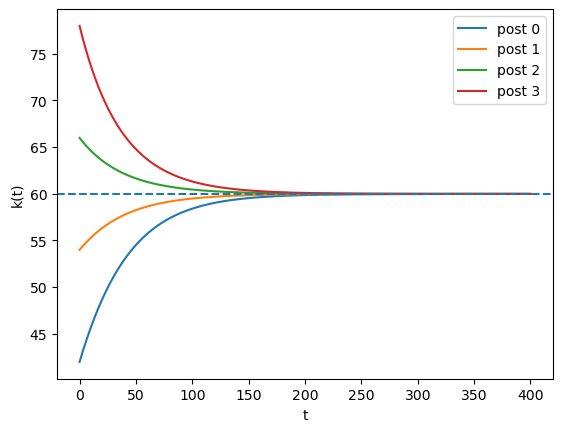

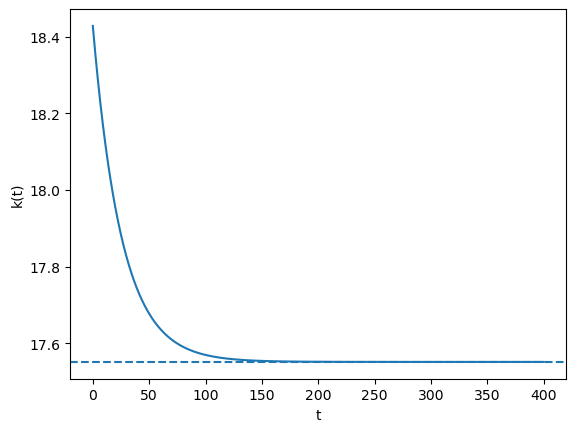

In [26]:
import matplotlib.pyplot as plt

# Post: k(t)
plt.figure()
for i, p in enumerate(paths["post"]):
    plt.plot(p["t"], p["k"], label=f"post {i}")
plt.axhline(sol["post"]["fp"]["k1_star"], linestyle="--")
plt.xlabel("t"); plt.ylabel("k(t)"); plt.legend(); plt.show()

# Pre: k(t)
plt.figure()
plt.plot(paths["pre"]["t"], paths["pre"]["k"])
plt.axhline(sol["pre"]["fp"]["k0_star"], linestyle="--")
plt.xlabel("t"); plt.ylabel("k(t)"); plt.show()
